In [115]:
from dotenv import load_dotenv
import os

import pandas as pd
import numpy as np
import math
from itertools import cycle, product

import statistics
import shap


#from datetime import datetime
import datetime

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import style
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

from scipy.stats import randint, uniform, shapiro
import scikitplot as skplt
import sklearn as sk
from sklearn import linear_model

from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, PowerTransformer, OneHotEncoder
from sklearn.preprocessing import FunctionTransformer, QuantileTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as ltb
import xgboost as xgb
import pmdarima as pm

import statsmodels.api as sm
import statsmodels
import statsmodels.stats.api as sms
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
import statsmodels.tsa.api as smt
from statsmodels.tools import eval_measures
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_white, het_arch
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller


from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from fredapi import Fred
import pandas_datareader as pdr

import warnings

In [116]:
sk.set_config(display='diagram')
warnings.filterwarnings("ignore")
shap.initjs()

pd.set_option('display.float_format', lambda x: f'{x:,.4f}')
plt.rcParams["figure.figsize"] = (10,6)

# Plotting using Seaborn
sns.set(style="whitegrid")
style.use("seaborn-white")

In [117]:
load_dotenv()

fred_api_key = os.getenv("fred_api_key")
fred = Fred(api_key=fred_api_key)

In [118]:
from common.load_features import get_recession, add_recession_feature, get_fed_chair, add_fed_chair
from common.load_data import load_taylor,load_misery, time_split
from common.calc_metrics import model_results
from common.LinearRegDiagnostic import LinearRegDiagnostic

# Setup

## variables

In [119]:
rand_int = 12

#  Set start date
start_date = datetime.date(1940, 1, 1)
start_date_str = datetime.datetime.strftime(start_date, "%Y-%m-%d")

#  Federal Reserve Economic Data Service
data_source = 'fred'

# Functions

In [120]:
t0_df = load_taylor()
train0_df, test0_df = time_split(t0_df)

model_stats_df = model_results('ffef_tr_train', train0_df['FEDFUNDS'], train0_df['ffef_tr'], 0, None)
model_stats_df = model_results('ffef_tr_test', test0_df['FEDFUNDS'], test0_df['ffef_tr'], 0, model_stats_df)
                              
model_stats_df = model_results('ffef_tr2_train', train0_df['FEDFUNDS'], train0_df['ffef_tr2'], 0, model_stats_df )
model_stats_df = model_results('ffef_tr2_test', test0_df['FEDFUNDS'], test0_df['ffef_tr2'], 0, model_stats_df )                         

model_stats_df

t1_df: (1007, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
cpi_df: (909, 2)
holston_df: (250, 4)
ff_cpi_df: (832, 2)
train_df:  (197, 25)
test_df:  (49, 25)


name     mse   rmse    mape    mae aic
0   ffef_tr_train 25.4002 5.0399  2.1100 4.4310   0
1    ffef_tr_test 57.2779 7.5682 41.6492 6.8936   0
2  ffef_tr2_train  1.1202 1.0584  0.2525 0.6816   0
3   ffef_tr2_test  0.3307 0.5750  3.4681 0.4071   0

model_stats_df = model_results('Naive_test', train0_df['FEDFUNDS'], train0_df['FEDFUNDS-1'], train0_df.shape[0], 1  , None )
model_stats_df = model_results('Naive_test', test0_df['FEDFUNDS'], test0_df['FEDFUNDS-1'], test0_df.shape[0], 1  , model_stats_df )

In [121]:
t0_df[['FEDFUNDS_diff','ffef_tr','ffef_tr2']].head(20)

FEDFUNDS_diff  ffef_tr  ffef_tr2
DATE                                        
1962-03-31         0.0567   6.2727    2.9153
1962-06-30         0.1500   6.4035    2.9762
1962-09-30         0.2400   6.3189    3.0635
1962-12-31         0.0767   5.8494    3.2198
1963-03-31         0.0433   5.7059    3.2700
1963-06-30        -0.0033   5.6283    3.2579
1963-09-30         0.3667   6.3850    3.3755
1963-12-31         0.1233   6.7786    3.6533
1964-03-31         0.0100   7.1770    3.8250
1964-06-30         0.0267   7.2625    3.8105
1964-09-30        -0.0333   7.6125    3.7579
1964-12-31         0.1200   6.8851    3.7322
1965-03-31         0.4000   7.7287    3.8700
1965-06-30         0.1033   8.2717    4.3104
1965-09-30        -0.0033   8.9184    4.4502
1965-12-31         0.0900   9.9187    4.4932
1966-03-31         0.3933  11.0850    4.7457
1966-06-30         0.3533  11.2096    5.1000
1966-09-30         0.4967  11.9718    5.5280
1966-12-31         0.1533  12.0808    6.0126

In [122]:
t0_df[['FEDFUNDS_diff','ffef_tr_diff','ffef_tr2_diff']].head(20)

FEDFUNDS_diff  ffef_tr_diff  ffef_tr2_diff
DATE                                                  
1962-03-31         0.0567        0.8192         0.6190
1962-06-30         0.1500        0.1308         0.0609
1962-09-30         0.2400       -0.0846         0.0873
1962-12-31         0.0767       -0.4694         0.1563
1963-03-31         0.0433       -0.1436         0.0502
1963-06-30        -0.0033       -0.0776        -0.0121
1963-09-30         0.3667        0.7568         0.1176
1963-12-31         0.1233        0.3936         0.2779
1964-03-31         0.0100        0.3984         0.1717
1964-06-30         0.0267        0.0855        -0.0145
1964-09-30        -0.0333        0.3500        -0.0525
1964-12-31         0.1200       -0.7274        -0.0258
1965-03-31         0.4000        0.8436         0.1378
1965-06-30         0.1033        0.5429         0.4404
1965-09-30        -0.0033        0.6467         0.1398
1965-12-31         0.0900        1.0004         0.0429
1966-03-31         0.3933        1.1662         0.2525
1966-06-30         0.3533        0.1246         0.3544
1966-09-30         0.4967        0.7623         0.4280
1966-12-31         0.1533        0.1090         0.4845

# Load Data

In [123]:
taylor_df = load_taylor()
#taylor_df = taylor_df.query('DATE >= "2000-01-01"').copy()
#taylor_df = taylor_df.query('DATE >= "1990-01-01" & DATE < "2007-01-01"').copy()
#taylor_df = taylor_df.query('DATE < "2007-01-01"').copy()
train_df, test_df = time_split(taylor_df)

t1_df: (1007, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
cpi_df: (909, 2)
holston_df: (250, 4)
ff_cpi_df: (832, 2)
train_df:  (197, 25)
test_df:  (49, 25)


In [124]:
#taylor_df['chair_name'].unique()
taylor_df.columns

Index(['FEDFUNDS', 'UNRATE', 'TB3MS', 'GDPC1', 'GDPPOT', 'GDPDEF_PC1',
       'CPIAUCSL_PC1', 'Growth_g', 'Real_Interest_Rate', 'Output_Gap',
       'FEDFUNDS_CPIAUCNS_PC1', 'FEDFUNDS-1', 'FEDFUNDS_diff',
       'FEDFUNDS_CPIAUCNS_PC1-1', 'FEDFUNDS_CPIAUCNS_PC1_diff', 'gap_inf',
       'gap_gdp', 'gap_ue', 'ffef_tr', 'ffef_tr2', 'ffef_tr_diff',
       'ffef_tr2_diff', 'recession_flag', 'chair_name', 'chair_index'],
      dtype='object')

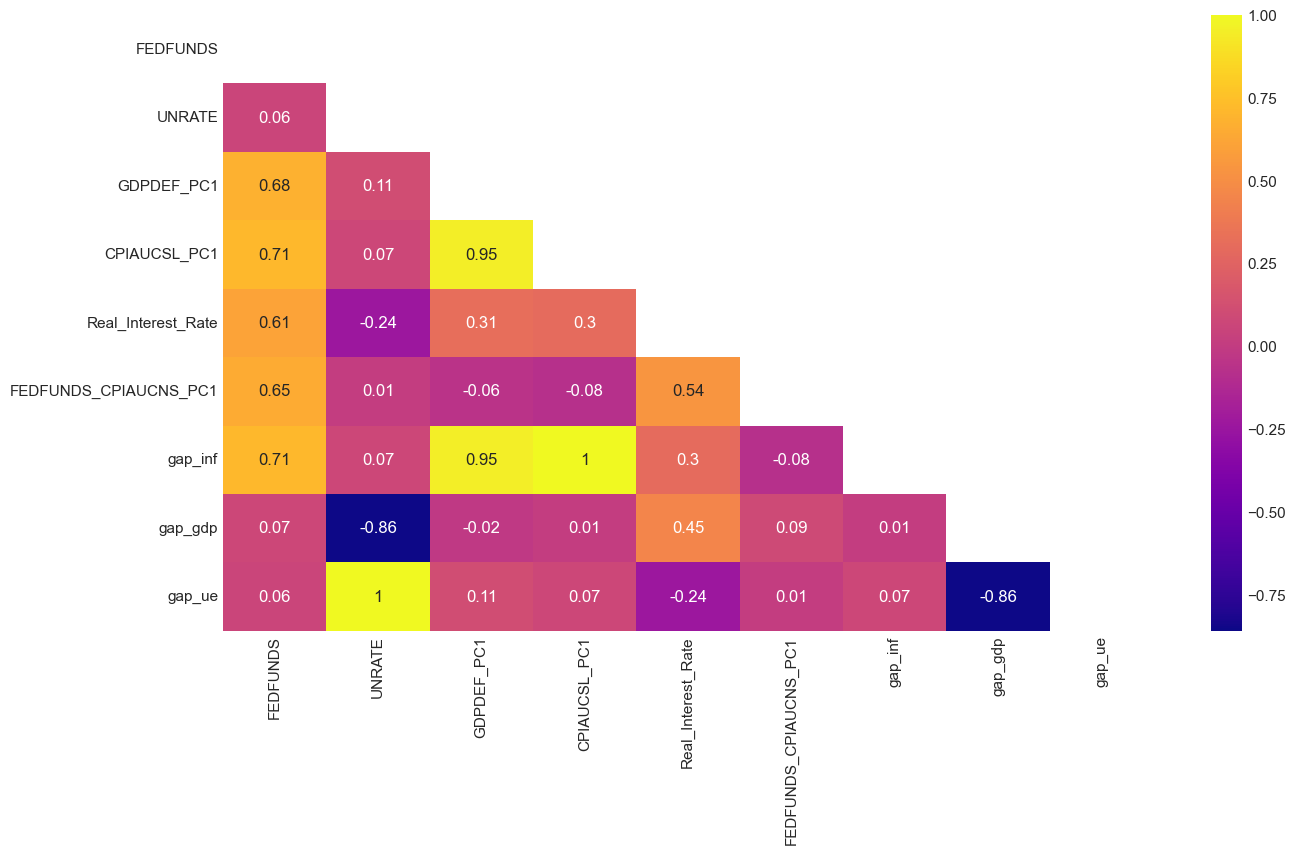

In [125]:
t_df = taylor_df[['FEDFUNDS', 'UNRATE', 'GDPDEF_PC1',
       'CPIAUCSL_PC1', 'Real_Interest_Rate',
       'FEDFUNDS_CPIAUCNS_PC1', 'gap_inf',
       'gap_gdp', 'gap_ue',]].copy()

plt.figure(figsize=(15,8))
mask = np.zeros_like(t_df.corr())
mask[np.triu_indices_from(mask)] = True
sns.set_style("white")
_p = sns.heatmap(t_df.corr().round(2), 
                 annot=True, mask=mask, 
                 cmap="plasma", annot_kws={"size": 12})

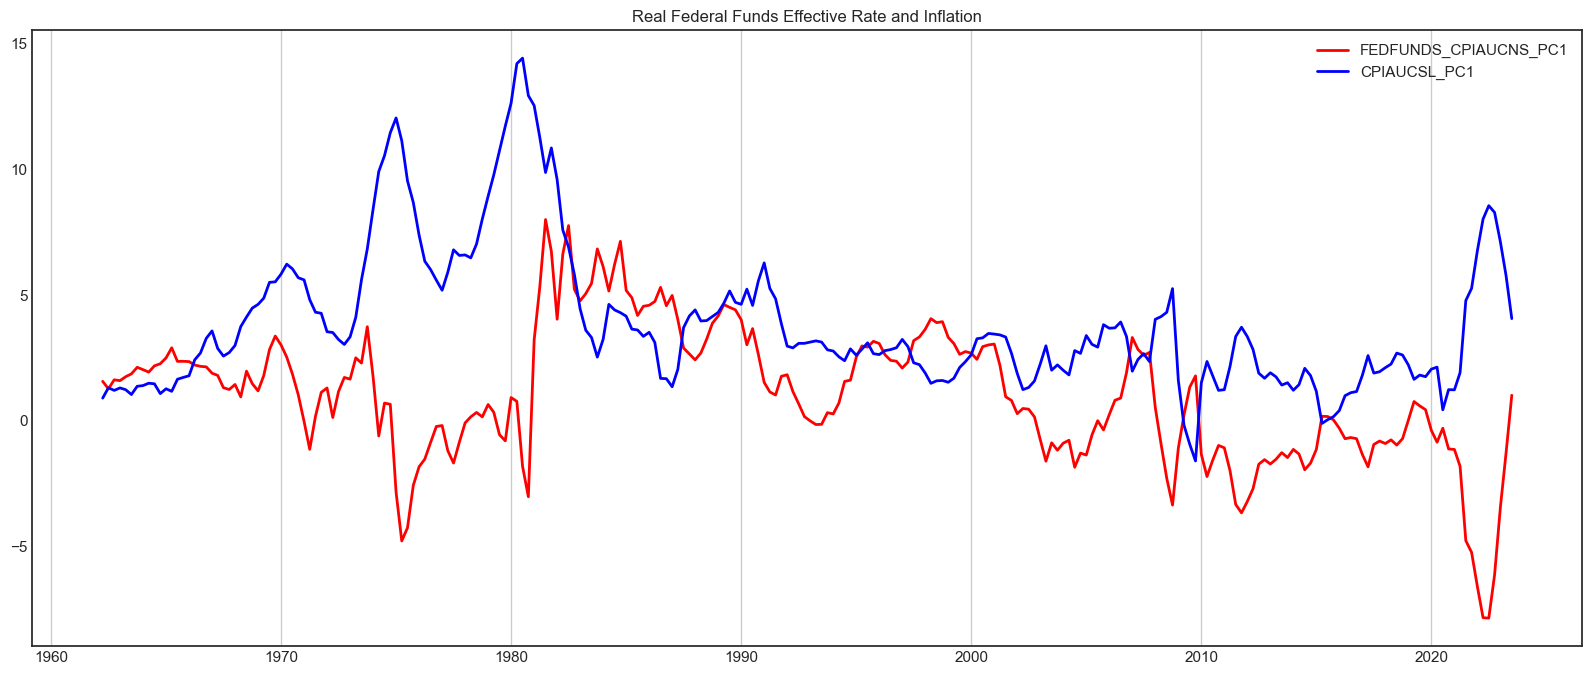

In [126]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(taylor_df.index, taylor_df['FEDFUNDS_CPIAUCNS_PC1'], 'red', linewidth=2)
ax.plot(taylor_df.index, taylor_df['CPIAUCSL_PC1'], 'blue', linewidth=2)
ax.legend(["FEDFUNDS_CPIAUCNS_PC1","CPIAUCSL_PC1"])
ax.set(title='Real Federal Funds Effective Rate and Inflation');
plt.show()

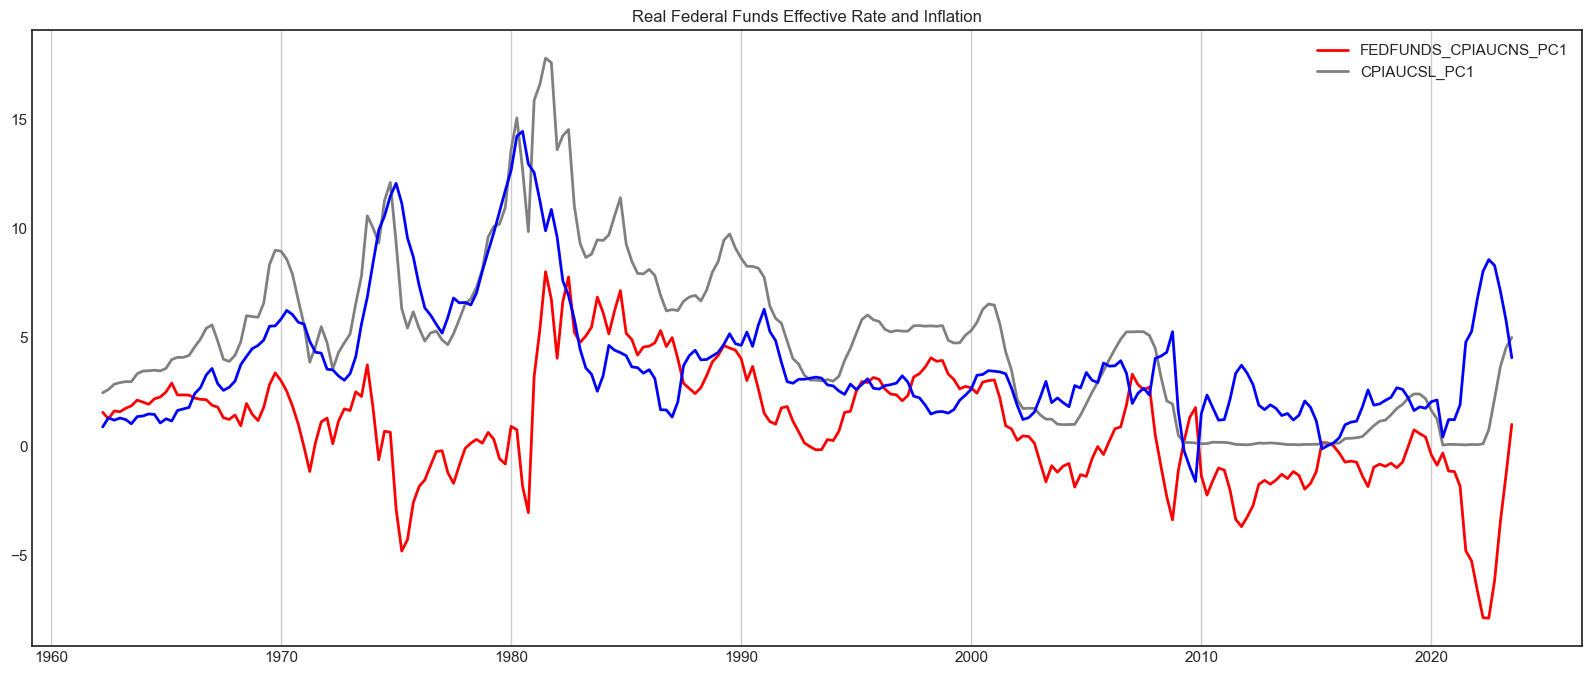

In [127]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(taylor_df.index, taylor_df['FEDFUNDS_CPIAUCNS_PC1'], 'red', linewidth=2)
ax.plot(taylor_df.index, taylor_df['FEDFUNDS'], 'gray', linewidth=2)
ax.plot(taylor_df.index, taylor_df['CPIAUCSL_PC1'], 'blue', linewidth=2)
ax.legend(["FEDFUNDS_CPIAUCNS_PC1","CPIAUCSL_PC1"])
ax.set(title='Real Federal Funds Effective Rate and Inflation');
plt.show()

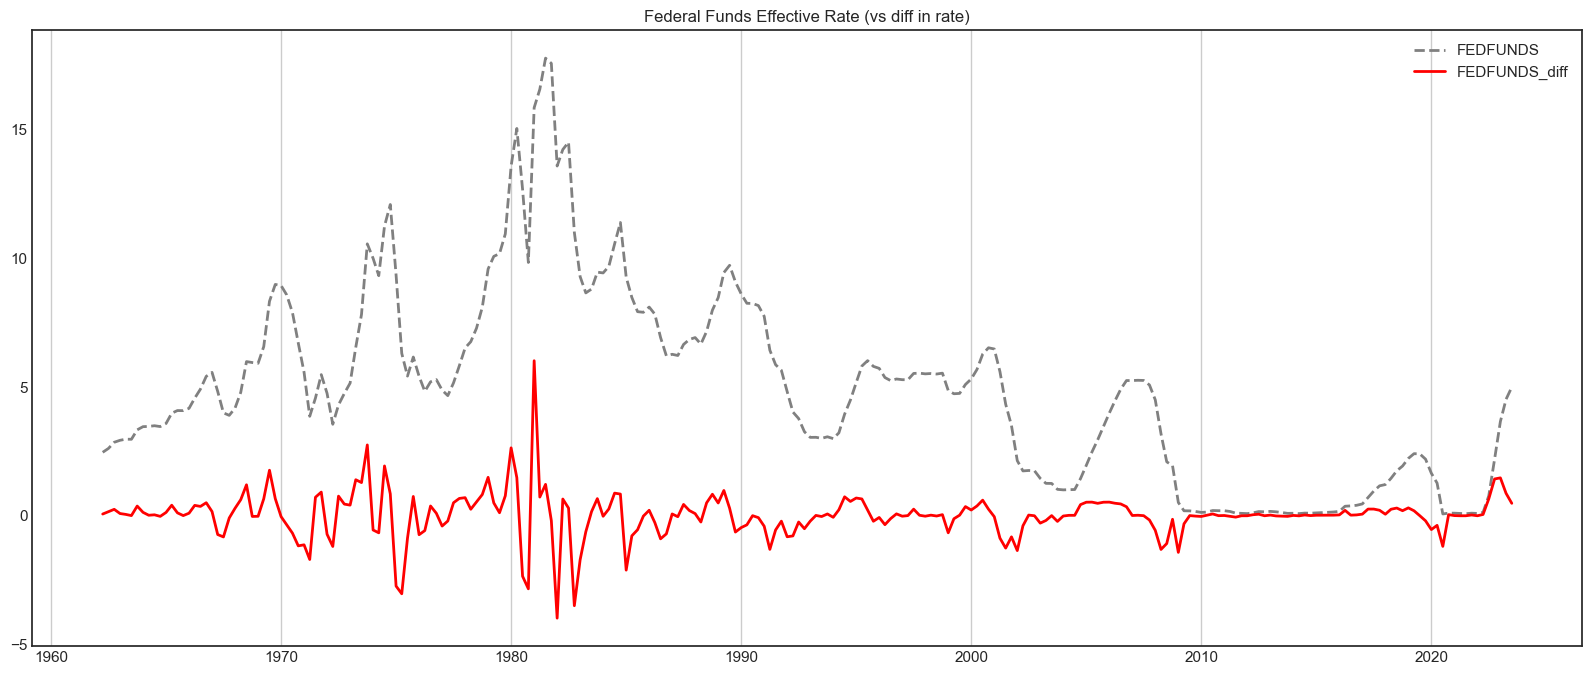

In [128]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(taylor_df.index, taylor_df['FEDFUNDS'], 'gray', linestyle='--', linewidth=2)
ax.plot(taylor_df.index, taylor_df['FEDFUNDS_diff'], 'red', linewidth=2)
ax.legend(["FEDFUNDS","FEDFUNDS_diff"])
ax.set(title='Federal Funds Effective Rate (vs diff in rate)');
plt.show()

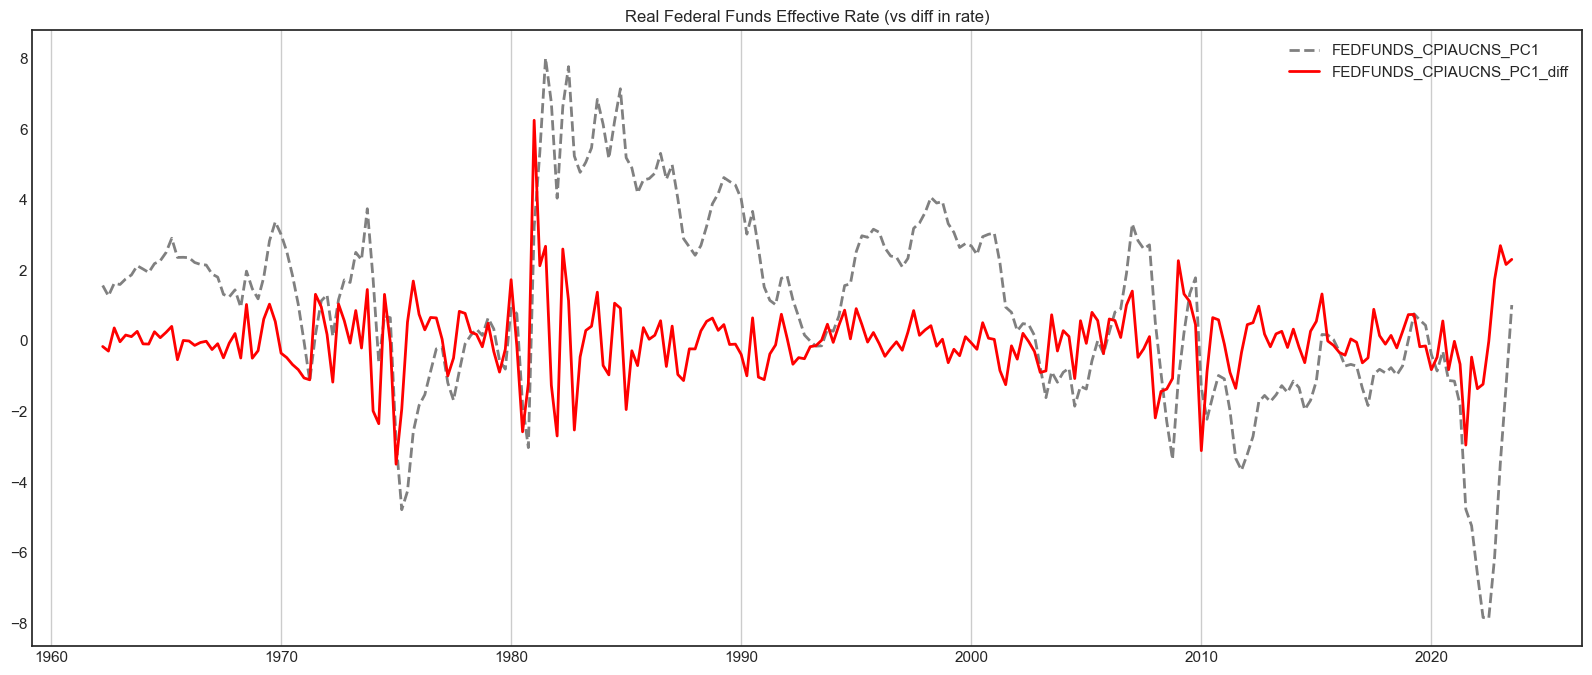

In [129]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(taylor_df.index, taylor_df['FEDFUNDS_CPIAUCNS_PC1'], 'gray', linestyle='--', linewidth=2)
ax.plot(taylor_df.index, taylor_df['FEDFUNDS_CPIAUCNS_PC1_diff'], 'red', linewidth=2)
ax.legend(["FEDFUNDS_CPIAUCNS_PC1","FEDFUNDS_CPIAUCNS_PC1_diff"])
ax.set(title='Real Federal Funds Effective Rate (vs diff in rate)');
plt.show()

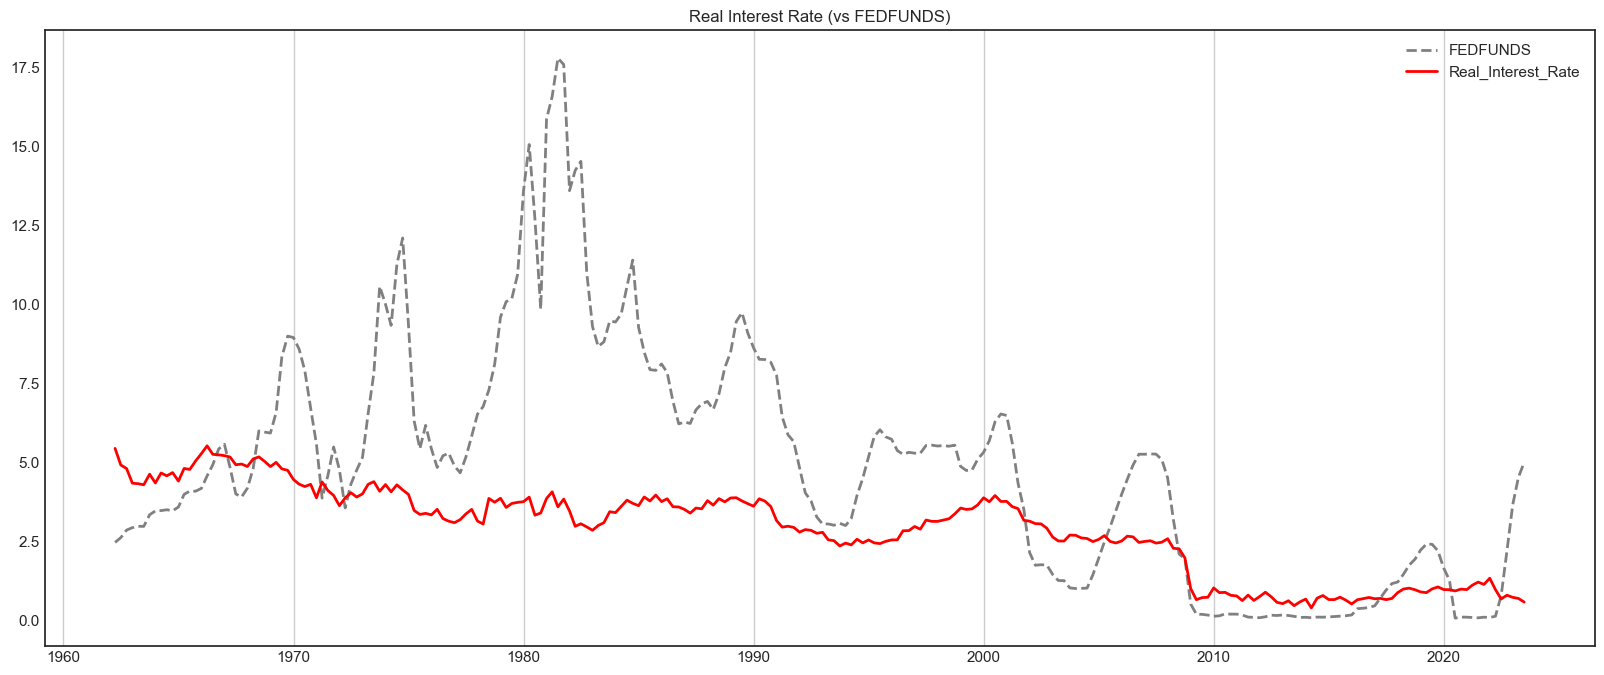

In [130]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(taylor_df.index, taylor_df['FEDFUNDS'], 'gray', linestyle='--', linewidth=2)
ax.plot(taylor_df.index, taylor_df['Real_Interest_Rate'], 'red', linewidth=2)
ax.legend(["FEDFUNDS","Real_Interest_Rate"])
ax.set(title='Real Interest Rate (vs FEDFUNDS)');
plt.show()

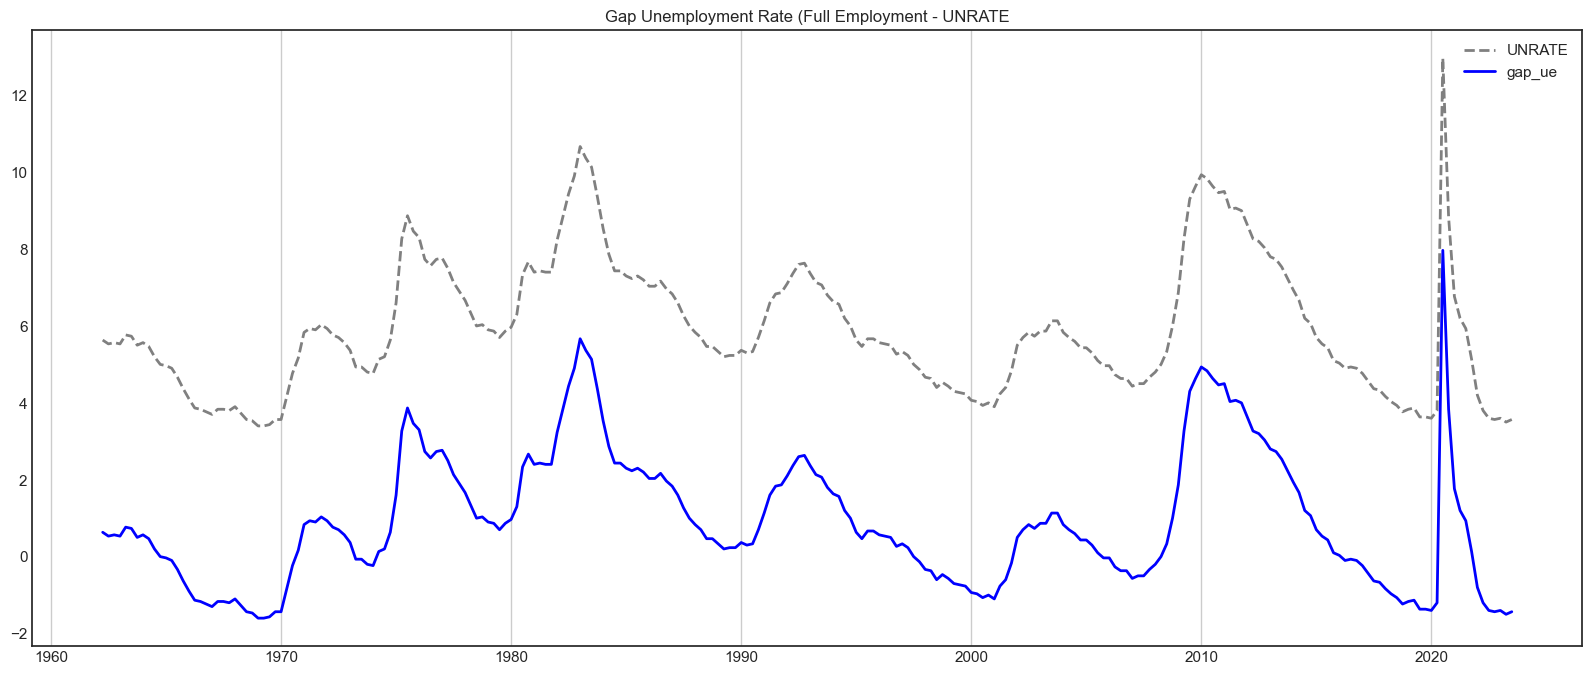

In [131]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(taylor_df.index, taylor_df['UNRATE'], 'gray', linestyle='--', linewidth=2)
ax.plot(taylor_df.index, taylor_df['gap_ue'], 'blue', linewidth=2)
ax.legend(["UNRATE","gap_ue"])
ax.set(title='Gap Unemployment Rate (Full Employment - UNRATE');
plt.show()

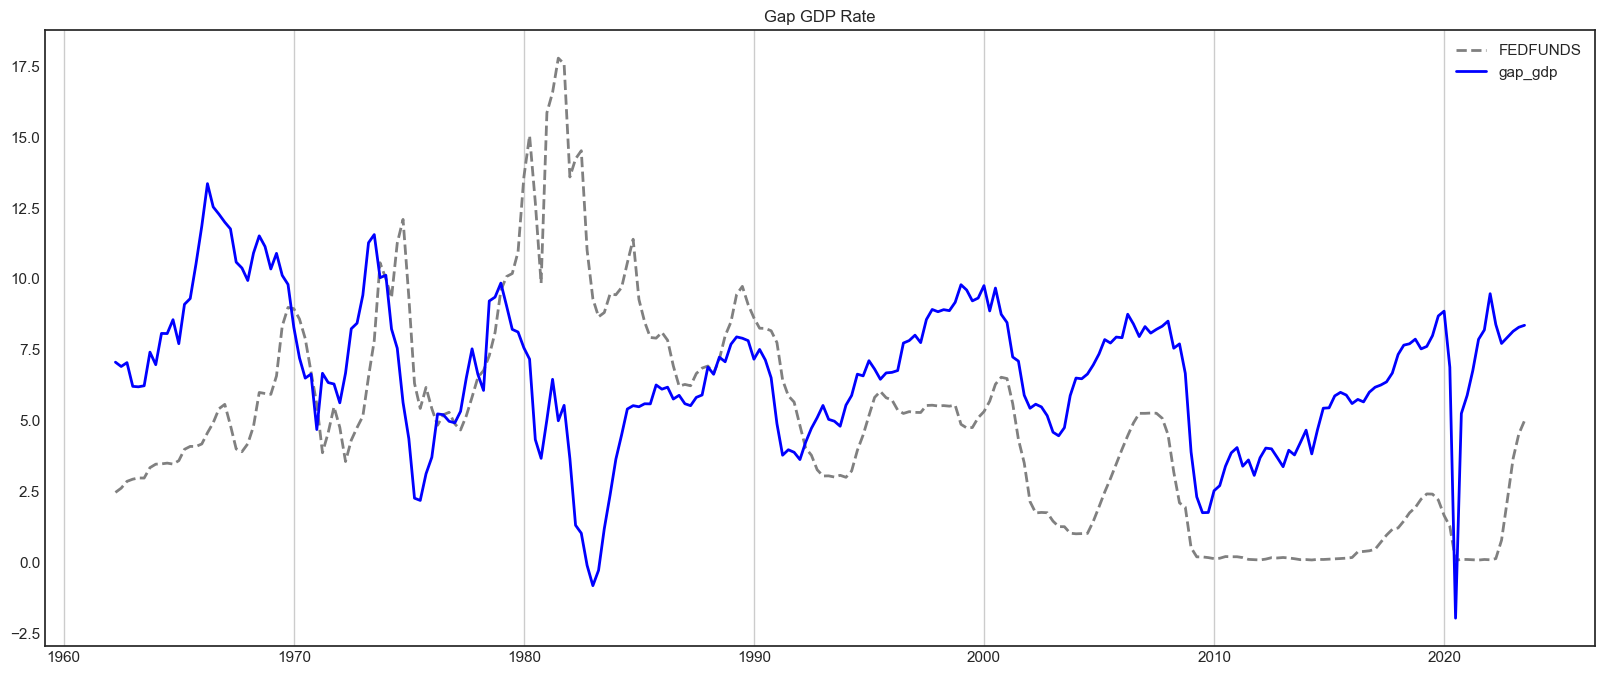

In [132]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(taylor_df.index, taylor_df['FEDFUNDS'], 'gray', linestyle='--', linewidth=2)
ax.plot(taylor_df.index, taylor_df['gap_gdp'], 'blue', linewidth=2)
ax.legend(["FEDFUNDS","gap_gdp"])
ax.set(title='Gap GDP Rate');
plt.show()

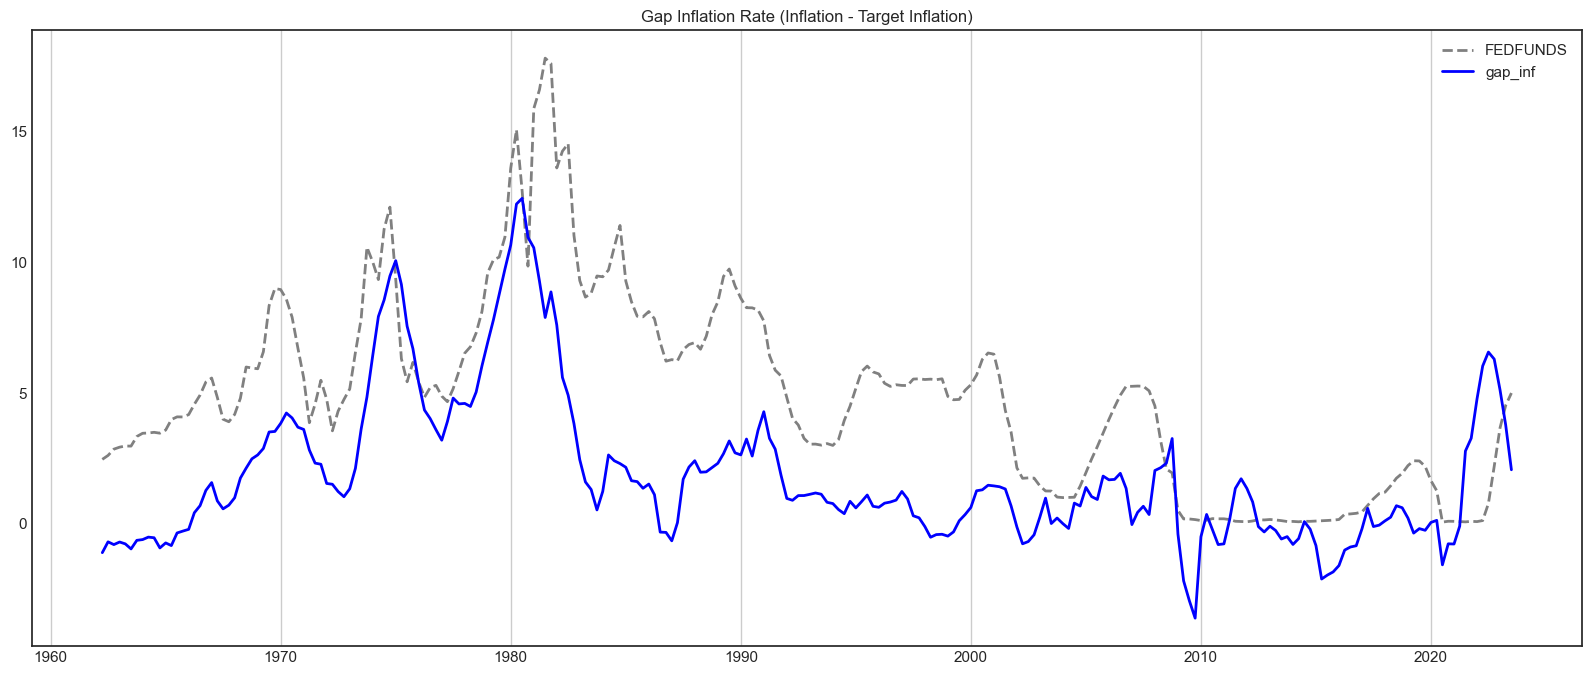

In [133]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(taylor_df.index, taylor_df['FEDFUNDS'], 'gray', linestyle='--', linewidth=2)
ax.plot(taylor_df.index, taylor_df['gap_inf'], 'blue', linewidth=2)
ax.legend(["FEDFUNDS","gap_inf"])
ax.set(title='Gap Inflation Rate (Inflation - Target Inflation)');
plt.show()

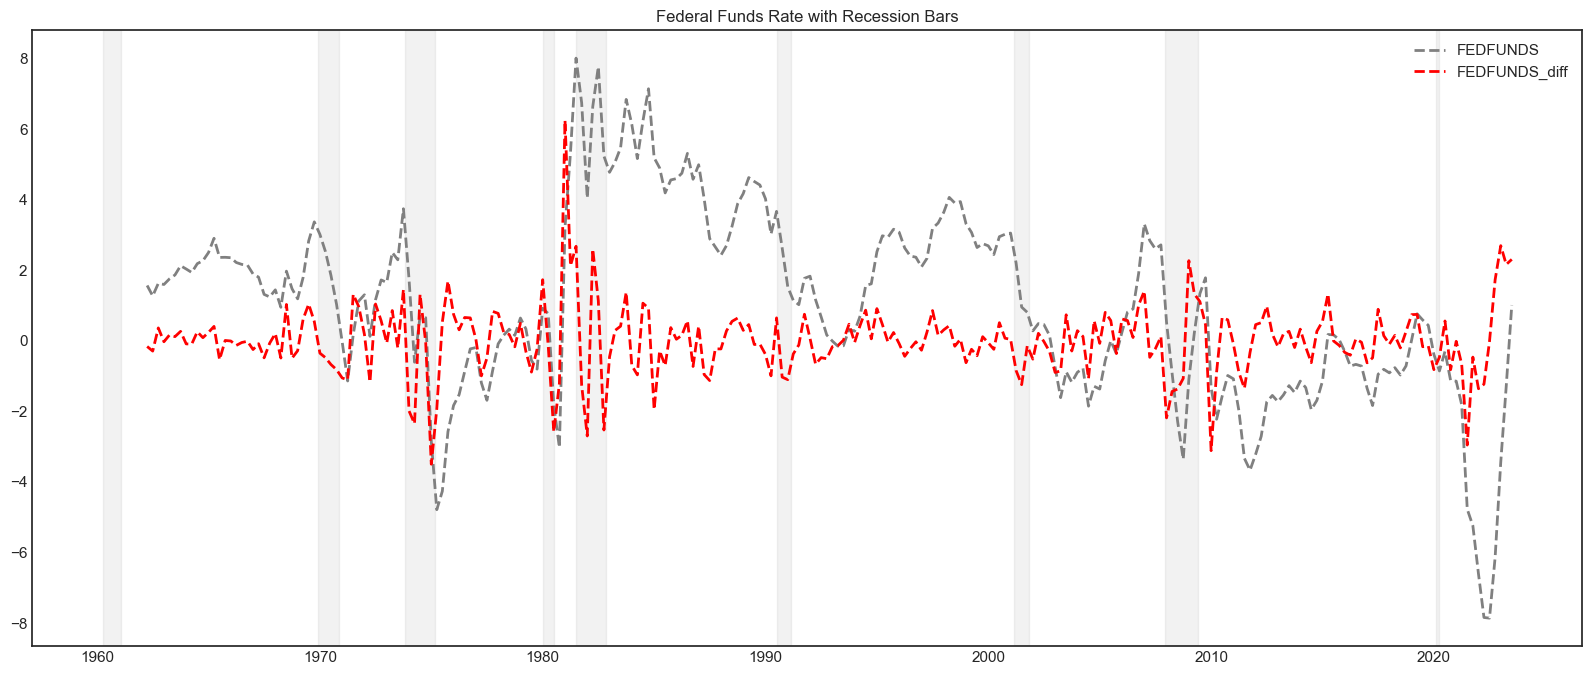

In [134]:
cycol = cycle('rgbcmyk')


t_df = taylor_df.query('DATE >= "1960-01-01"')
r_df = get_recession()
r_df = r_df.query('Peak_Date >= "1960-01-01"')

# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
ax.plot(taylor_df.index, taylor_df['FEDFUNDS_CPIAUCNS_PC1'], 'gray', linestyle='--', linewidth=2)
ax.plot(t_df.index, t_df['FEDFUNDS_CPIAUCNS_PC1_diff'], linestyle='--', color='red',linewidth=2)

# Plotting recession bars
for i,row in r_df.iterrows():
    plt.axvspan(row['Peak_Date'], row['Trough_Date'], color='gray', alpha=0.1)
   
ax.legend(["FEDFUNDS","FEDFUNDS_diff"])
ax.set(title='Federal Funds Rate with Recession Bars');
plt.show()

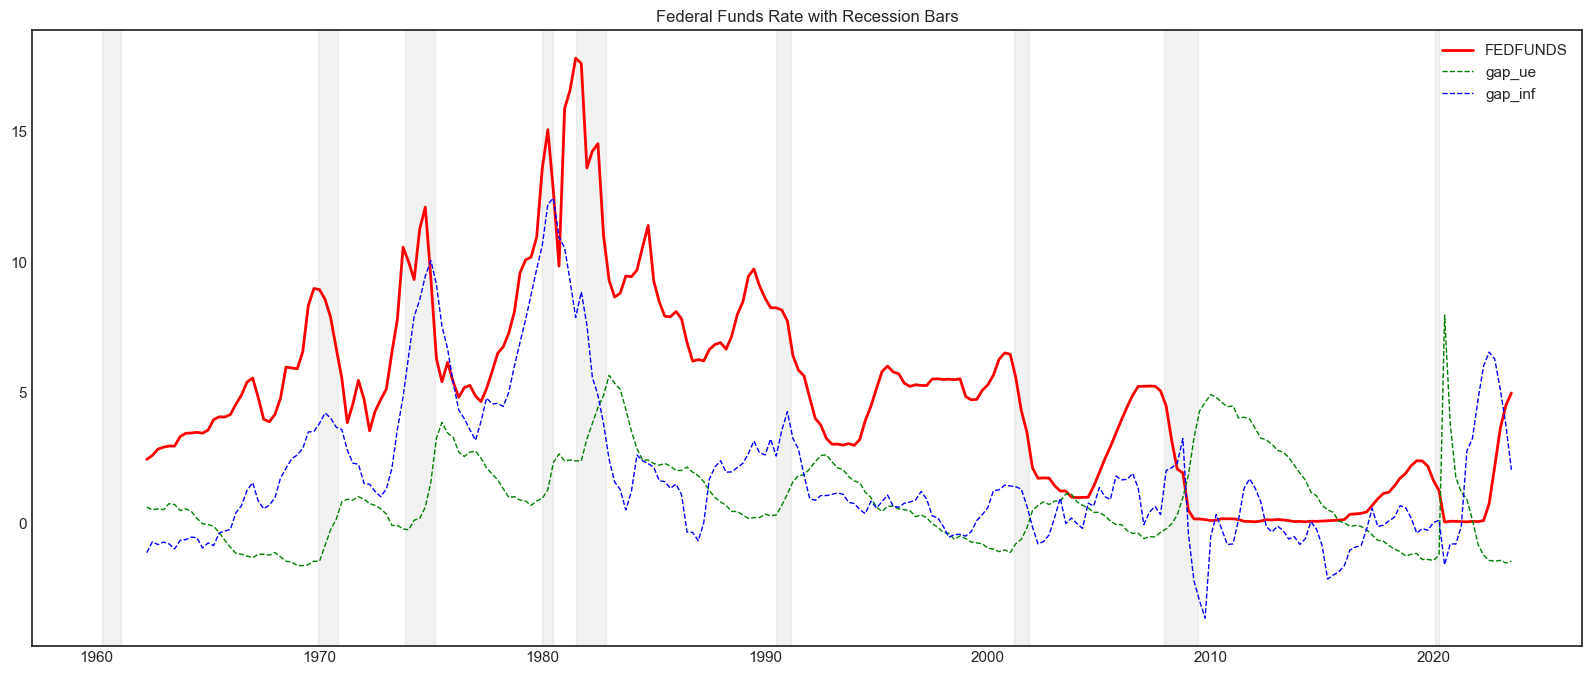

In [135]:
cycol = cycle('rgbcmyk')


t_df = taylor_df.query('DATE >= "1960-01-01"')
r_df = get_recession()
r_df = r_df.query('Peak_Date >= "1960-01-01"')

# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
ax.plot(taylor_df.index, taylor_df['FEDFUNDS'], 'red',  linewidth=2)
ax.plot(t_df.index, t_df['gap_ue'], linestyle='--', color='green',linewidth=1)
ax.plot(t_df.index, t_df['gap_inf'], linestyle='--', color='blue',linewidth=1)

# Plotting recession bars
for i,row in r_df.iterrows():
    plt.axvspan(row['Peak_Date'], row['Trough_Date'], color='gray', alpha=0.1)
   
ax.legend(["FEDFUNDS","gap_ue","gap_inf"])
ax.set(title='Federal Funds Rate with Recession Bars');
plt.show()

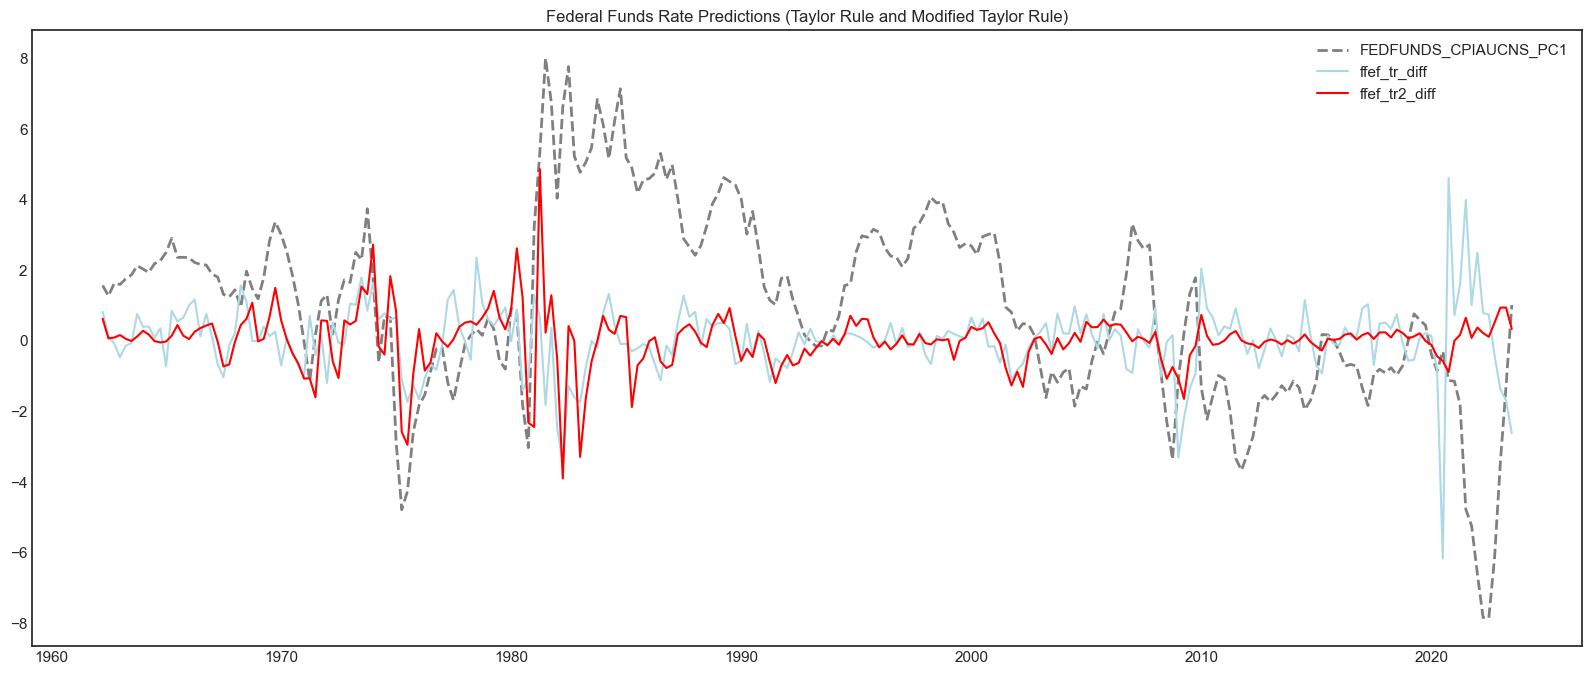

In [136]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plo3
ax.plot(taylor_df.index, taylor_df['FEDFUNDS_CPIAUCNS_PC1'], 'gray', linestyle='--', linewidth=2)
ax.plot(taylor_df.index, taylor_df['ffef_tr_diff'], color='lightblue', linewidth=1.5)
ax.plot(taylor_df.index, taylor_df['ffef_tr2_diff'], color='red', linewidth=1.5)

ax.legend(["FEDFUNDS_CPIAUCNS_PC1", "ffef_tr_diff","ffef_tr2_diff"])
ax.set(title='Federal Funds Rate Predictions (Taylor Rule and Modified Taylor Rule)');

plt.show()

In [137]:
taylor_df.columns

Index(['FEDFUNDS', 'UNRATE', 'TB3MS', 'GDPC1', 'GDPPOT', 'GDPDEF_PC1',
       'CPIAUCSL_PC1', 'Growth_g', 'Real_Interest_Rate', 'Output_Gap',
       'FEDFUNDS_CPIAUCNS_PC1', 'FEDFUNDS-1', 'FEDFUNDS_diff',
       'FEDFUNDS_CPIAUCNS_PC1-1', 'FEDFUNDS_CPIAUCNS_PC1_diff', 'gap_inf',
       'gap_gdp', 'gap_ue', 'ffef_tr', 'ffef_tr2', 'ffef_tr_diff',
       'ffef_tr2_diff', 'recession_flag', 'chair_name', 'chair_index'],
      dtype='object')

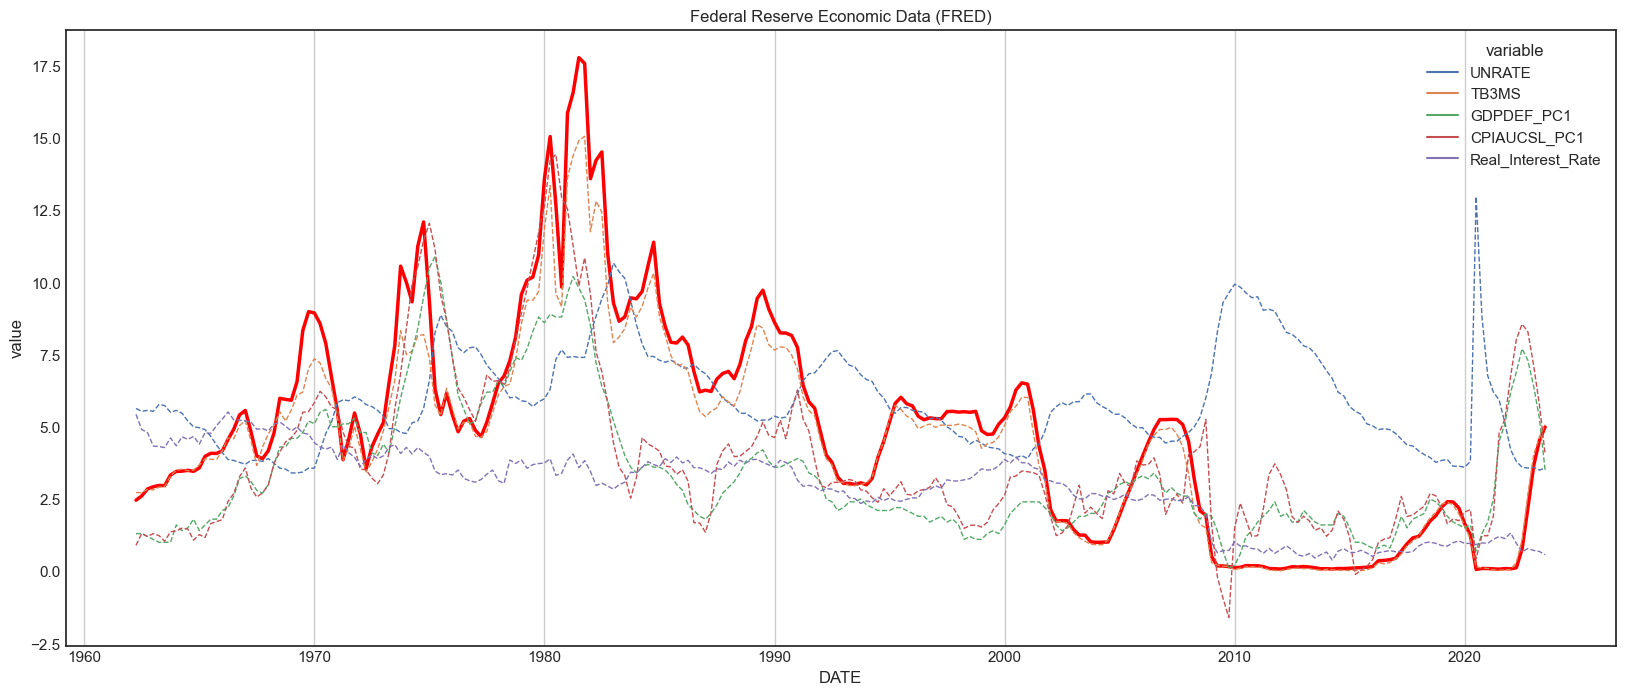

In [138]:
# Long 
long_df = taylor_df[['UNRATE','TB3MS','GDPDEF_PC1','CPIAUCSL_PC1','Real_Interest_Rate']].copy()
long_df.reset_index(inplace=True)
long_df = long_df.melt(id_vars=['DATE'])


# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(taylor_df.index, taylor_df['FEDFUNDS'], 'red', linewidth=2.5)
#ax.plot(taylor_df.index, taylor_df['UNRATE'], 'blue', linewidth=2)

sns.lineplot(x = 'DATE', y = 'value', data=long_df, hue='variable', linestyle='--',linewidth=1)

#ax.legend(["FEDFUNDS","gap_inf"])
ax.set(title='Federal Reserve Economic Data (FRED)');
plt.show()

# Case

In [139]:
#test_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue','gap_gdp','recession_flag', 'CPIAUCSL_PC1']]

In [140]:
#case = 1  # Full Model
case = 2  # Modified Taylor Rule
#case = 3  # Modified Taylor Rule - r*
#case = 4  # Recession Model
#case = 5  # Simple Model
#case = 6  # Recession Model (minus Real Interest Rates)
#case = 7  # Real FFER
#case = 8  # CPIAUCSL_PC1 UNRATE
#case = 9  # Feature Selection ARIMA
#case = 10  # Federal Chair
#case = None  # Feature Selection

# Initialize Variables
X_train = None
y_train = None
X_test = None
y_test = None

# Initialize Imputer
preprocessor = None




if case == 1:
    
    print('-- Full Model')
    X_train = train_df[['gap_inf','gap_ue','CPIAUCSL_PC1','UNRATE']] 
    #X_train = X_train + 10
    y_train = train_df['FEDFUNDS']


    X_test = test_df[['gap_inf','gap_ue','CPIAUCSL_PC1','UNRATE']]
    #X_test = X_test + 10
    y_test = test_df['FEDFUNDS']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    #num_columns_lst = ['FEDFUNDS-1', 'gap_inf', 'gap_ue','Real_Interest_Rate']
    num_columns_lst = ['gap_inf','gap_ue','CPIAUCSL_PC1','UNRATE']
    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
        ]
    )   
    
    
elif case == 2:
    
    print('-- Modified Taylor Rule')
    #X_train = train_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue','Real_Interest_Rate']]
    X_train = train_df[['gap_inf', 'gap_ue','Real_Interest_Rate','FEDFUNDS-1']]
    y_train = train_df['FEDFUNDS_diff']


    #X_test = test_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue','Real_Interest_Rate']]
    X_test = test_df[['gap_inf', 'gap_ue','Real_Interest_Rate','FEDFUNDS-1']]
    y_test = test_df['FEDFUNDS_diff']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    #num_columns_lst = ['FEDFUNDS-1', 'gap_inf', 'gap_ue','Real_Interest_Rate']
    num_columns_lst = ['gap_inf', 'gap_ue','Real_Interest_Rate','FEDFUNDS-1']
    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
        ]
    )
    
elif case == 3:
    
    print('-- Modified Taylor Rule (-r*)')
    #X_train = train_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue','Real_Interest_Rate']]
    X_train = train_df[['gap_inf', 'gap_ue','FEDFUNDS-1']]
    y_train = train_df['FEDFUNDS']


    #X_test = test_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue','Real_Interest_Rate']]
    X_test = test_df[['gap_inf', 'gap_ue','FEDFUNDS-1']]
    y_test = test_df['FEDFUNDS']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    #num_columns_lst = ['FEDFUNDS-1', 'gap_inf', 'gap_ue','Real_Interest_Rate']
    num_columns_lst = ['gap_inf', 'gap_ue','FEDFUNDS-1']
    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
        ]
    )
    
    
elif case == 4:
    print('-- Recession Model')
    X_train = train_df[['gap_inf', 'gap_ue','recession_flag']]
    y_train = train_df['FEDFUNDS']


    X_test = test_df[['gap_inf', 'gap_ue','recession_flag']]
    y_test = test_df['FEDFUNDS']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    cat_columns_lst = ['recession_flag']
    num_columns_lst = ['gap_inf', 'gap_ue']


    ohe_categories = list()
    for c in cat_columns_lst:
        ohe_categories.append(list(X_train[c].unique()))

    ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                       sparse_output=False, handle_unknown='ignore')

    transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')


    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])
    categorical_transformer = Pipeline( steps=[('transformer',transformer)])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
            ("cat", categorical_transformer, cat_columns_lst),
        ]
    )

elif case == 5:
    print('-- Simplified Model')
    X_train = train_df[[ 'gap_inf', 'gap_ue']]
    #X_train = train_df[['gap_inf', 'gap_ue']]
    y_train = train_df['FEDFUNDS']


    X_test = test_df[[ 'gap_inf', 'gap_ue']]
    #X_test = test_df[['gap_inf', 'gap_ue']]
    y_test = test_df['FEDFUNDS']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    #scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    num_columns_lst = ['gap_inf', 'gap_ue']
    #num_columns_lst = ['gap_inf', 'gap_ue']
    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
        ]
    )

    
elif case == 6:
    print('-- Recession Model (minus Real Interest Rates)')
    X_train = train_df[['gap_inf', 'gap_ue','recession_flag','FEDFUNDS-1']]
    y_train = train_df['FEDFUNDS']


    X_test = test_df[['gap_inf', 'gap_ue','recession_flag','FEDFUNDS-1']]
    y_test = test_df['FEDFUNDS']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    cat_columns_lst = ['recession_flag']
    num_columns_lst = ['gap_inf', 'gap_ue','FEDFUNDS-1']


    ohe_categories = list()
    for c in cat_columns_lst:
        ohe_categories.append(list(X_train[c].unique()))

    ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                       sparse_output=False, handle_unknown='ignore')

    transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')


    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])
    categorical_transformer = Pipeline( steps=[('transformer',transformer)])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
            ("cat", categorical_transformer, cat_columns_lst),
        ]
    )
    
elif case == 7:
    print('-- Real Fed Funds Rate')
    X_train = train_df[['gap_inf', 'gap_ue']]
    y_train = train_df['FEDFUNDS_CPIAUCNS_PC1']


    X_test = test_df[['gap_inf', 'gap_ue']]
    y_test = test_df['FEDFUNDS_CPIAUCNS_PC1']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()

    # Initialize Transformer / OneHotEncoder
    #num_columns_lst = ['FEDFUNDS-1', 'gap_inf', 'gap_ue','Real_Interest_Rate']
    num_columns_lst = ['gap_inf', 'gap_ue']
    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
        ]
    )

elif case == 8:
    print('-- Simplified Model')
    X_train = train_df[[ 'UNRATE', 'CPIAUCSL_PC1']]
    #X_train = train_df[['gap_inf', 'gap_ue']]
    y_train = train_df['FEDFUNDS']


    X_test = test_df[[ 'UNRATE', 'CPIAUCSL_PC1']]
    #X_test = test_df[['gap_inf', 'gap_ue']]
    y_test = test_df['FEDFUNDS']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    num_columns_lst = ['UNRATE', 'CPIAUCSL_PC1']
    #num_columns_lst = ['gap_inf', 'gap_ue']
    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
        ]
    )
    
    
elif case == 9:
    print('-- All Variables ARIMA')
    X_train = train_df[['gap_inf', 'gap_gdp','recession_flag','FEDFUNDS-1']] 
    #X_train = X_train + 10
    y_train = train_df['FEDFUNDS']


    X_test = test_df[['gap_inf', 'gap_gdp','recession_flag','FEDFUNDS-1']]
    #X_test = X_test + 10
    y_test = test_df['FEDFUNDS']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()
    #scaler_num = PowerTransformer(method='box-cox')
    #scaler_num = FunctionTransformer(np.log1p, validate=True)
    #scaler_num = QuantileTransformer(random_state=rand_int)

    # Initialize Transformer / OneHotEncoder
    cat_columns_lst = ['recession_flag']
    num_columns_lst = ['gap_inf', 'gap_gdp','FEDFUNDS-1']


    ohe_categories = list()
    for c in cat_columns_lst:
        ohe_categories.append(list(X_train[c].unique()))

    ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                       sparse_output=False, handle_unknown='ignore')

    transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')


    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])
    categorical_transformer = Pipeline( steps=[('transformer',transformer)])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
            ("cat", categorical_transformer, cat_columns_lst),
        ]
    )    

elif case == 10:
    print('-- Federal Reserve')
    X_train = train_df[['gap_inf', 'gap_gdp','recession_flag','FEDFUNDS-1','chair_name']] 
    #X_train = X_train + 10
    y_train = train_df['FEDFUNDS']


    X_test = test_df[['gap_inf', 'gap_gdp','recession_flag','FEDFUNDS-1','chair_name']]
    #X_test = X_test + 10
    y_test = test_df['FEDFUNDS']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()
    #scaler_num = PowerTransformer(method='box-cox')
    #scaler_num = FunctionTransformer(np.log1p, validate=True)
    #scaler_num = QuantileTransformer(random_state=rand_int)

    # Initialize Transformer / OneHotEncoder
    cat_columns_lst = ['recession_flag','chair_name']
    num_columns_lst = ['gap_inf', 'gap_gdp','FEDFUNDS-1']


    ohe_categories = list()
    for c in cat_columns_lst:
        ohe_categories.append(list(X_train[c].unique()))

    ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                       sparse_output=False, handle_unknown='ignore')

    transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')


    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])
    categorical_transformer = Pipeline( steps=[('transformer',transformer)])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
            ("cat", categorical_transformer, cat_columns_lst),
        ]
    )   
    
    
else:
    print('-- All Variables')
    X_train = train_df[['gap_inf', 'gap_gdp','gap_ue','Real_Interest_Rate','recession_flag','FEDFUNDS-1']] 
    #X_train = X_train + 10
    y_train = train_df['FEDFUNDS']


    X_test = test_df[['gap_inf', 'gap_gdp','gap_ue','Real_Interest_Rate','recession_flag','FEDFUNDS-1']]
    #X_test = X_test + 10
    y_test = test_df['FEDFUNDS']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()
    #scaler_num = PowerTransformer(method='box-cox')
    #scaler_num = FunctionTransformer(np.log1p, validate=True)
    #scaler_num = QuantileTransformer(random_state=rand_int)

    # Initialize Transformer / OneHotEncoder
    cat_columns_lst = ['recession_flag']
    num_columns_lst = ['gap_inf', 'gap_gdp','gap_ue','Real_Interest_Rate','FEDFUNDS-1']


    ohe_categories = list()
    for c in cat_columns_lst:
        ohe_categories.append(list(X_train[c].unique()))

    ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                       sparse_output=False, handle_unknown='ignore')

    transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')


    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])
    categorical_transformer = Pipeline( steps=[('transformer',transformer)])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
            ("cat", categorical_transformer, cat_columns_lst),
        ]
    )    


-- Modified Taylor Rule


In [141]:
y_train = y_train.asfreq('Q')

t_fit = preprocessor.fit(X_train)
t_fit.get_feature_names_out()
X_train_trf = t_fit.transform(X_train)

#X_train_trf.columns = 
X_train_trf = pd.DataFrame(X_train_trf)
feature_names = t_fit.get_feature_names_out()
X_train_trf.columns = feature_names
X_train_trf['DATE'] = y_train.index
X_train_trf.set_index('DATE', inplace=True)
X_train_trf = X_train_trf.asfreq('Q')

print('X_train_trf: ', X_train_trf.shape)



X_train_trf:  (197, 4)


# Diagnostics

- Differencing Order (d): The 'd' parameter in SARIMA specifies the differencing order. If your data is already stationary, you might not need to difference it further (i.e., set 'd' to zero). If the data is non-stationary, you might need to apply differencing to achieve stationarity.
- Auto-Differencing (Seasonal and Regular Differencing): SARIMA models can handle both regular differencing (e.g., 'd' for regular differences) and seasonal differencing (e.g., 'D' for seasonal differences) within the model. This auto-differencing capability allows the model to incorporate differencing as part of its structure.

In [142]:
lag_num = min(10, train_df.shape[0]//5)
alpha = 0.05

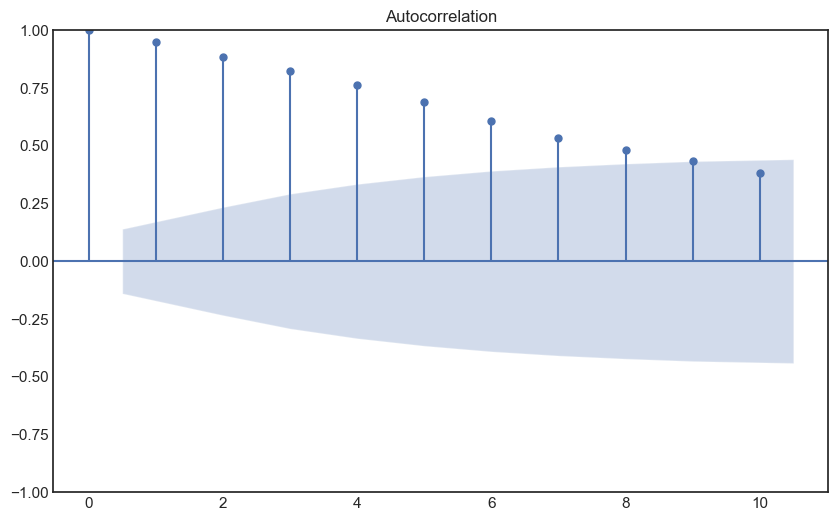

In [143]:
acf = smt.graphics.plot_acf(train_df['FEDFUNDS'], lags=lag_num , alpha=alpha)
acf.show()

Augmented Dickey-Fuller test - 
- If the p-value is less than a chosen significance level (e.g., 0.05), you can reject the null hypothesis of non-stationarity and conclude that the time series is stationary.
- If the p-value is greater than the chosen significance level, there is insufficient evidence to reject the null hypothesis, suggesting that the time series might be non-stationary.

Critical Values
- If the ADF statistic is less (i.e., more negative) than the critical value at a chosen significance level (e.g., 1%), it indicates evidence against the null hypothesis of non-stationarity.
- ADF Stat < critical value - stationary
- ADF Stat > critical value - non stationary

In [144]:
# Perform Augmented Dickey-Fuller test
adf_result = adfuller(train_df['FEDFUNDS'])

# Extract and print test results
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -1.9252017481545174
p-value: 0.3202998543937755
Critical Values:
   1%: -3.4654311561944873
   5%: -2.8769570530458792
   10%: -2.574988319755886


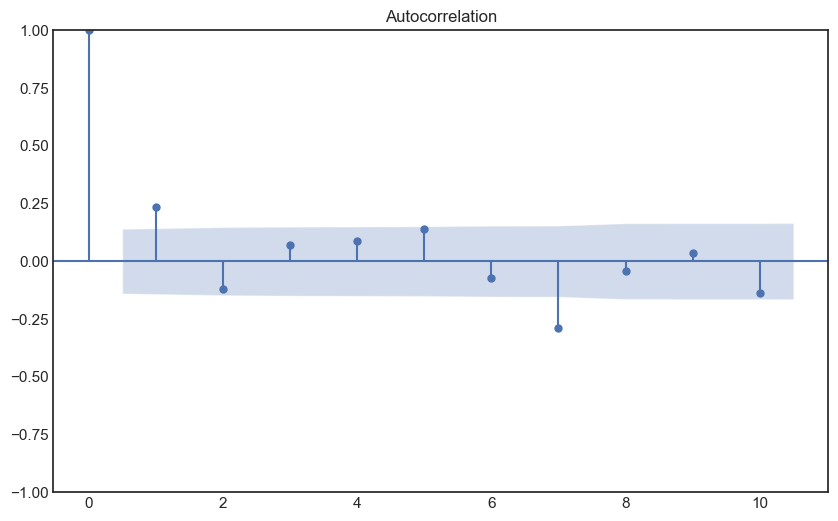

In [145]:
acf = smt.graphics.plot_acf(train_df['FEDFUNDS_diff'], lags=lag_num , alpha=alpha)
acf.show()

In [146]:
# Perform Augmented Dickey-Fuller test
adf_result = adfuller(train_df['FEDFUNDS_diff'])

# Extract and print test results
print('ADF Statistic:', adf_result[0])
print('p-value:', round(adf_result[1],6))
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -6.105236206429481
p-value: 0.0
Critical Values:
   1%: -3.4652439354133255
   5%: -2.8768752281673717
   10%: -2.574944653739612



1. Stationarity: SARIMA assumes that the time series data is stationary or can be made stationary after differencing. Stationarity means that the statistical properties of the series (mean, variance, autocorrelation, etc.) remain constant over time.

- First Difference makes that data stationary
- Seasonal Component (S): Captures the seasonality in the time series data.
- Autoregressive Component (AR): Represents the dependence between an observation and a number of lagged observations.
- Differencing (I): Refers to differencing the time series data to make it stationary.
- Moving Average Component (MA): Captures the dependency between an observation and a residual error from a moving average model.

# tsa.SARIMAX

In [147]:
if True:
    # Define ranges for p, d, q, P, D, Q, S
    p = d = q = range(0, 4)

    # Generate all possible combinations of parameters
    param_combinations = list(product(p, d, q))

    # Fit models and select the best one based on evaluation criteria
    best_aic = np.inf
    best_order = None
    best_seasonal_order = None

    for param in param_combinations:
        print('param: ', param)
        try:
            model = sm.tsa.SARIMAX(y_train, enforce_stationarity=True, exog=X_train_trf , order=param[:3], seasonal_order=(0, 0, 0,0))
            results = model.fit(disp=0)
            aic = results.aic
            if aic < best_aic:
                best_aic = aic
                best_order = param[:3]
                best_seasonal_order = param[3:]
        except:
            continue

    print(f"Best SARIMAX Order: {best_order}")
    #print(f"Best SARIMAX Seasonal Order: {best_seasonal_order}")

param:  (0, 0, 0)
param:  (0, 0, 1)
param:  (0, 0, 2)
param:  (0, 0, 3)
param:  (0, 1, 0)
param:  (0, 1, 1)
param:  (0, 1, 2)
param:  (0, 1, 3)
param:  (0, 2, 0)
param:  (0, 2, 1)
param:  (0, 2, 2)
param:  (0, 2, 3)
param:  (0, 3, 0)
param:  (0, 3, 1)
param:  (0, 3, 2)
param:  (0, 3, 3)
param:  (1, 0, 0)
param:  (1, 0, 1)
param:  (1, 0, 2)
param:  (1, 0, 3)
param:  (1, 1, 0)
param:  (1, 1, 1)
param:  (1, 1, 2)
param:  (1, 1, 3)
param:  (1, 2, 0)
param:  (1, 2, 1)
param:  (1, 2, 2)
param:  (1, 2, 3)
param:  (1, 3, 0)
param:  (1, 3, 1)
param:  (1, 3, 2)
param:  (1, 3, 3)
param:  (2, 0, 0)
param:  (2, 0, 1)
param:  (2, 0, 2)
param:  (2, 0, 3)
param:  (2, 1, 0)
param:  (2, 1, 1)
param:  (2, 1, 2)
param:  (2, 1, 3)
param:  (2, 2, 0)
param:  (2, 2, 1)
param:  (2, 2, 2)
param:  (2, 2, 3)
param:  (2, 3, 0)
param:  (2, 3, 1)
param:  (2, 3, 2)
param:  (2, 3, 3)
param:  (3, 0, 0)
param:  (3, 0, 1)
param:  (3, 0, 2)
param:  (3, 0, 3)
param:  (3, 1, 0)
param:  (3, 1, 1)
param:  (3, 1, 2)
param:  (3

In [148]:
#model = sm.tsa.SARIMAX(y_train, order=(1,0,0), seasonal_order=(0, 0, 0, 4),enforce_stationarity=True, exog=X_train_trf)
model = sm.tsa.SARIMAX(y_train, order=best_order, seasonal_order=(0, 0, 0, 0) ,enforce_stationarity=True, exog=X_train_trf)
#model = sm.tsa.SARIMAX(y_train, order=(0,1,0), enforce_stationarity=True, exog=X_train_trf)
result_model = model.fit(disp=False)

result_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          FEDFUNDS_diff   No. Observations:                  197
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -229.200
Date:                Mon, 01 Jan 2024   AIC                            476.400
Time:                        19:59:48   BIC                            505.903
Sample:                    03-31-1962   HQIC                           488.344
                         - 03-31-2011                                         
Covariance Type:                  opg                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
num__gap_inf                0.8975      0.284      3.155      0.002       0.340       1.455
num__gap_ue                -2.3382      0.330     -7.086      0.000      -2.985      -1.691
num__Real_Interest_Rate     0.1013      0.354      0.286      0.775      -0.592       0.795
num__FEDFUNDS-1            -4.3421      0.406    -10.692      0.000      -5.138      -3.546
ar.L1                       0.2399      0.084      2.872      0.004       0.076       0.404
ar.L2                      -0.9055      0.050    -18.063      0.000      -1.004      -0.807
ma.L1                      -0.1550      0.155     -1.001      0.317      -0.459       0.148
ma.L2                       0.7651      0.086      8.893      0.000       0.596       0.934
sigma2                      0.6054      0.042     14.438      0.000       0.523       0.688
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):              1413.52
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                             1.70
Prob(H) (two-sided):                  0.04   Kurtosis:                        15.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<br><br>

**Warnings**

Covariance matrix calculation using the outer product of gradients (complex-step):
- issues with the stability of standard errors.
- Generally, this warning message itself is not an issue unless it's accompanied by other warnings related to convergence or instability.

<br>

Covariance matrix is singular or near-singular, with a high condition number:

- The condition number measures the stability of the covariance matrix. A high condition number (in your case, 3.37e+16) indicates that the matrix is nearly singular or ill-conditioned.
- An ill-conditioned covariance matrix could lead to unstable standard errors for parameter estimates. It implies that the estimation process might be numerically challenging, making the model results less reliable.

<br>

**kurtosi**

Here's a basic interpretation of kurtosis in the context of SARIMA modeling:

<br>

+ Positive Kurtosis:
    - A positive kurtosis indicates that the distribution of residuals has heavier tails and is more peaked (leptokurtic) than a normal distribution.
    - In the context of SARIMA, positive kurtosis might suggest that the residuals have more extreme values (outliers) or a higher likelihood of extreme events than a normal distribution.

<br>

+ Negative Kurtosis:
    - Negative kurtosis indicates that the distribution of residuals has lighter tails and is less peaked (platykurtic) than a normal distribution.
    - In the context of SARIMA, negative kurtosis might suggest that the residuals have fewer extreme values or flatter tails compared to a normal distribution.

<br>

+ Interpretation Caveat:
    - While kurtosis provides information about the shape of the distribution, it's important not to solely rely on kurtosis to draw conclusions about the residuals' behavior. It's essential to consider other measures and conduct thorough diagnostics, such as visual inspections, normality tests, and additional statistical assessments.


In [149]:
train_result = result_model.get_prediction(start=-len(X_train_trf), dynamic=True)
train_pred_SARIM = train_result.summary_frame()

<br>

### Model Diagnostics

The plot_diagnostics() function generates a set of four plots:

- Standardized Residuals Plot: Displays the standardized residuals over time. Look for patterns or large deviations from zero, indicating potential issues with the model's fit or variance. **Check for constant variance, patterns, or outliers.**
- Histogram Plus Estimated Density: Shows the histogram of residuals along with an estimated density plot. It helps in assessing the normality assumption of the residuals. 
- Normal Q-Q Plot: A quantile-quantile (Q-Q) plot compares the distribution of residuals against a theoretical normal distribution. Deviations from the diagonal line suggest non-normality. **Assess the normality assumption of residuals. Deviations from a straight line indicate non-normality.**
- Correlogram: Plots the autocorrelation function (ACF) of the residuals to detect any remaining autocorrelation. **Look for any significant autocorrelation in residuals.**

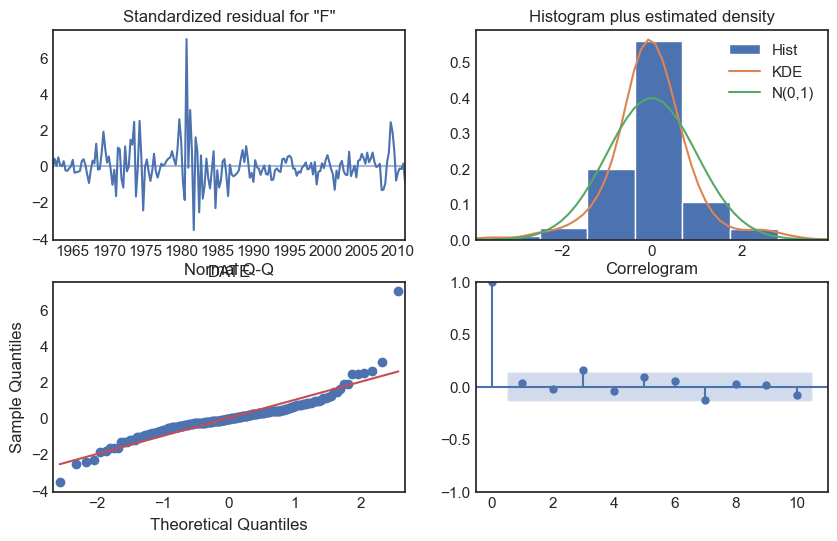

In [150]:
result_model.plot_diagnostics()
plt.show()

In [151]:
table = result_model.summary().tables[1].data
table_df = pd.DataFrame(table[1:], columns=table[0])
table_df.columns = ['feature','coef','std_err','z','p_value','[0.025','0.975]']
table_df = table_df[['feature','coef','p_value']]
table_df['coef'] = pd.to_numeric(table_df['coef'], errors='coerce')
table_df['p_value'] = pd.to_numeric(table_df['p_value'], errors='coerce')
table_df['color'] = np.where(table_df['p_value'] > 0.05, 'lightgray', '#1f77b4')

table_df

feature    coef  p_value      color
0             num__gap_inf  0.8975   0.0020    #1f77b4
1              num__gap_ue -2.3382   0.0000    #1f77b4
2  num__Real_Interest_Rate  0.1013   0.7750  lightgray
3          num__FEDFUNDS-1 -4.3421   0.0000    #1f77b4
4                    ar.L1  0.2399   0.0040    #1f77b4
5                    ar.L2 -0.9055   0.0000    #1f77b4
6                    ma.L1 -0.1550   0.3170  lightgray
7                    ma.L2  0.7651   0.0000    #1f77b4
8                   sigma2  0.6054   0.0000    #1f77b4

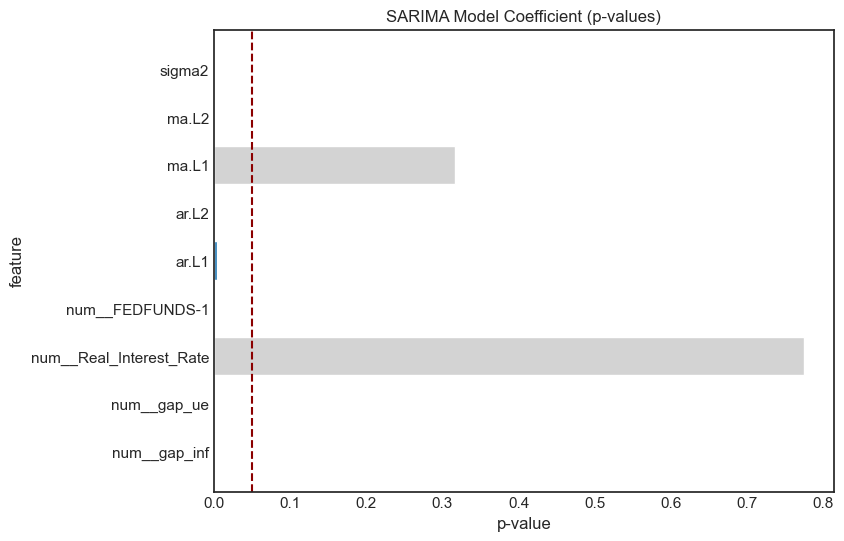

In [152]:
# Plot the MSE values against alphas
plt.figure(figsize=(8, 6))
plt.barh(table_df['feature'], table_df['p_value'], color=table_df['color'])

#plt.legend()
plt.xlabel('p-value')
plt.ylabel('feature')
plt.title('SARIMA Model Coefficient (p-values)')
plt.axvline(x=0.05, color='darkred', linestyle='--', label='Threshold: x = 0.05')

plt.grid(False)
plt.show()

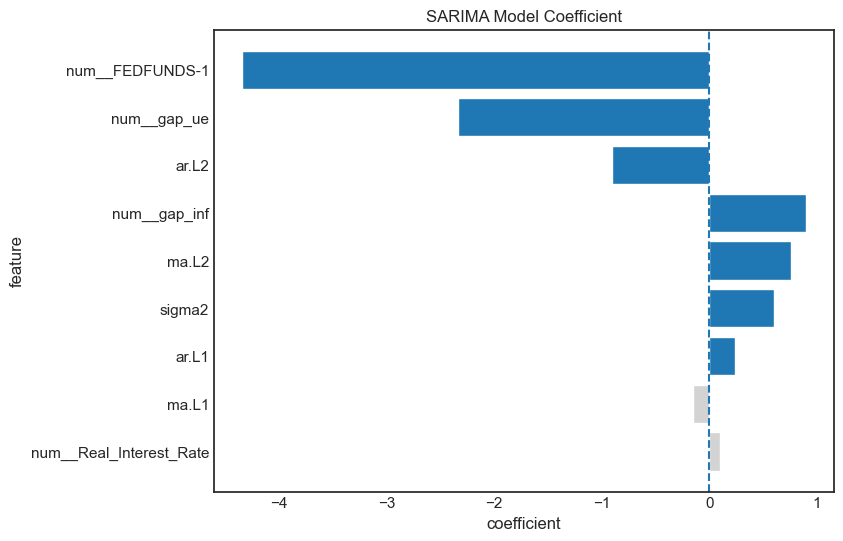

In [153]:
# Plot the MSE values against alphas
t_df = table_df.sort_values(by=['coef'], key=pd.Series.abs , ascending=True ).copy()
#t_df = table_df

plt.figure(figsize=(8, 6))
plt.barh(t_df['feature'], t_df['coef'], color=t_df['color'])

#plt.legend()
plt.xlabel('coefficient')
plt.ylabel('feature')
plt.title('SARIMA Model Coefficient')
plt.axvline(x=0, color='#1f77b4', linestyle='--', label='Threshold: x = 0.05')

plt.grid(False)
plt.show()

### Observations

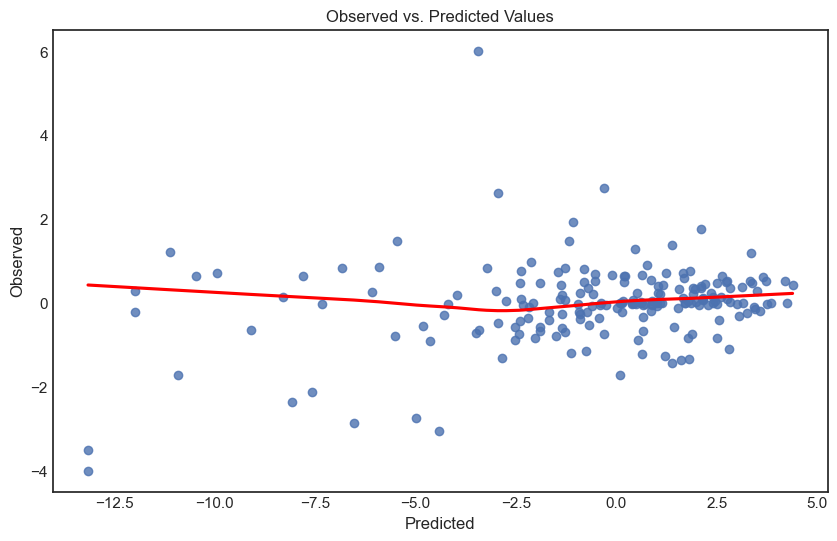

In [154]:
fig, ax = plt.subplots(1)

sns.regplot(x=train_pred_SARIM['mean'], y=y_train, lowess=True, ax=ax, line_kws={'color': 'red'})
ax.set_title('Observed vs. Predicted Values', fontsize=12)
ax.set(xlabel='Predicted', ylabel='Observed')

plt.show()


### Residuals Analysis

**No Seasonal Patterns** in Residuals: The residuals should not exhibit any seasonality or pattern after fitting the SARIMA model.
Visual Inspection: Observe the plot for any visible patterns in the variance of residuals. Departures from constant variance could indicate heteroskedasticity.
- residual plot and the acf plot

**Independence of Errors:** SARIMA assumes that the residuals (errors) of the model are independent and identically distributed (i.i.d.). Residuals should not exhibit patterns or correlation after fitting the model. 
- Ljung-Box

Normality of Residuals: While not as critical as in some other models, it's beneficial if residuals are normally distributed. Departures from normality might suggest that the model doesn't capture all the information in the data.
- skip this test

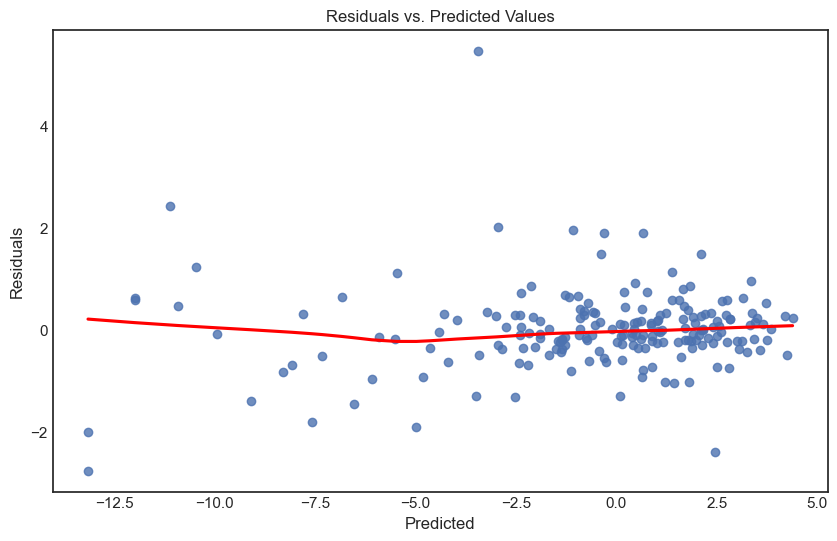

In [155]:
# independence of residuals
residuals = result_model.resid

fig, ax = plt.subplots(1)
sns.regplot(x=train_pred_SARIM['mean'], y=residuals, lowess=True, ax=ax, line_kws={'color': 'red'})
ax.set_title('Residuals vs. Predicted Values', fontsize=12)
ax.set(xlabel='Predicted', ylabel='Residuals')

plt.show()

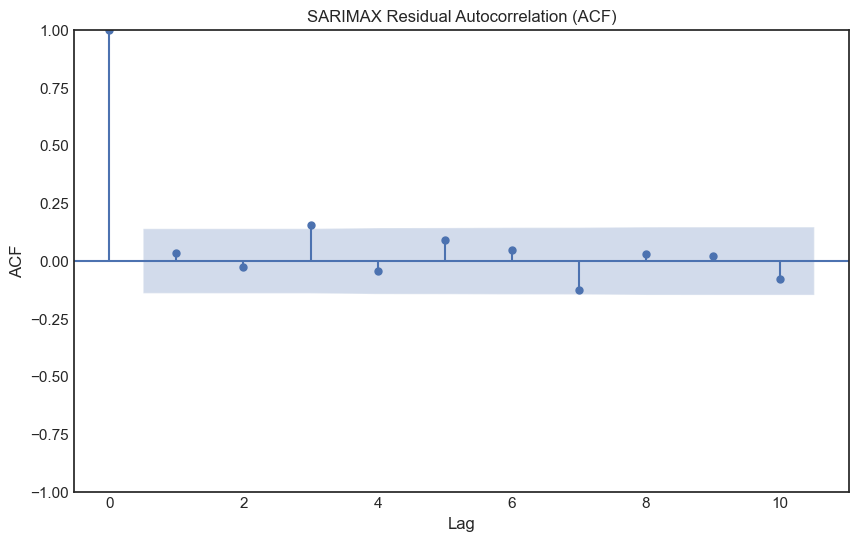

In [156]:
acf = smt.graphics.plot_acf(residuals, lags=lag_num , alpha=alpha)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.title('SARIMAX Residual Autocorrelation (ACF)')
acf.show()

The **Ljung-Box** test is used to assess whether autocorrelation exists in a time series at different lag intervals. It examines whether there is any significant correlation between the residuals of a model at various lags.

- H0: The residuals are independently distributed. (< 0.05 evidence of autocorrelation)
- HA: The residuals are not independently distributed; they exhibit serial correlation (> 0.05 fail to reject null hypothesis)

Autocorrelation in residuals implies that the model has not captured all the information in the time series data.
Ideally, residuals should not display significant autocorrelation, indicating that the model has successfully accounted for the temporal dependencies in the data.

heteroskedastic - the variance of the residuals is not constant

In [157]:
#lags = min(10, len(residuals)//5)

res = result_model.test_serial_correlation(method='ljungbox', lags=lag_num)
res_df = pd.DataFrame({ 'lag' : range(1, lag_num+1),
                        'test_statistic' : res[:,0][0],
                        'p_value' : res[:,1][0]})
res_df

lag  test_statistic  p_value
0    1          0.2368   0.6265
1    2          0.3271   0.8491
2    3          5.4254   0.1432
3    4          5.7802   0.2162
4    5          7.5925   0.1802
5    6          8.0790   0.2324
6    7         11.4315   0.1209
7    8         11.5565   0.1721
8    9         11.6170   0.2358
9   10         13.0774   0.2194

**Heteroskedasticity (changing variance)**

- If we used a heteroskedastic robust estimate of the covariance matrix, maybe we would correct for that weird result.
- Constant Variance: The variance of the residuals should remain constant across time. Heteroskedasticity (changing variance) in residuals can affect the reliability of model results.
- p_val < 0.05 suggest heteroskedasticity

In [158]:
test_stat, p_val = result_model.test_heteroskedasticity(method = 'breakvar')[0]
print('--- heteroskedasticity -- ')
print('test_stat: ',test_stat, '  ' , 'p_val: ', p_val)

--- heteroskedasticity -- 
test_stat:  0.5901950802363196    p_val:  0.03525366069524354


The het_arch() function performs the Ljung-Box test for the squared residuals to test for the presence of autocorrelation in squared residuals, indicating heteroskedasticity. A low p-value (< 0.05) suggests evidence against the null hypothesis of no heteroskedasticity, indicating the presence of heteroskedasticity in the time series residuals.

ARCH Test: A lower p-value (< 0.05) suggests evidence against constant variance (presence of heteroskedasticity). 

A higher p-value indicates that there is no strong evidence against constant variance.

In [159]:
res = het_arch(residuals)
print('--- heteroskedasticity -- ')
print('Ljung-Box Test Results: ',res[0], '  ' , 'p_val: ', round(res[1],10))

--- heteroskedasticity -- 
Ljung-Box Test Results:  26.06285295981863    p_val:  0.0036565655


In [160]:
print('aic', result_model.aic)

aic 476.39968423021935


## Test

In [161]:
X_test_trf = t_fit.transform(X_test)
X_test_trf = pd.DataFrame(X_test_trf)
X_test_trf.columns = t_fit.get_feature_names_out()
X_test_trf['DATE'] = test_df.index
X_test_trf.set_index('DATE', inplace=True)


y_test = test_df['FEDFUNDS']

In [162]:
s_idx = len(X_train_trf)
e_idx = s_idx + len(X_test_trf) - 1

test_result = result_model.get_prediction(start=s_idx, end=e_idx, exog=X_test_trf, dynamic=True)

In [163]:
test_pred_SARIM = test_result.summary_frame()
test_pred_SARIM.shape

(49, 4)

In [164]:
predict_ci = test_result.conf_int(alpha=0.5)
predict_ci.columns = ['lower', 'upper']
predict_ci.head()

lower  upper
2011-06-30 -0.2002 0.8494
2011-09-30 -0.0200 1.5286
2011-12-31  0.2160 2.0663
2012-03-31  0.2256 2.2840
2012-06-30 -0.2579 2.0258

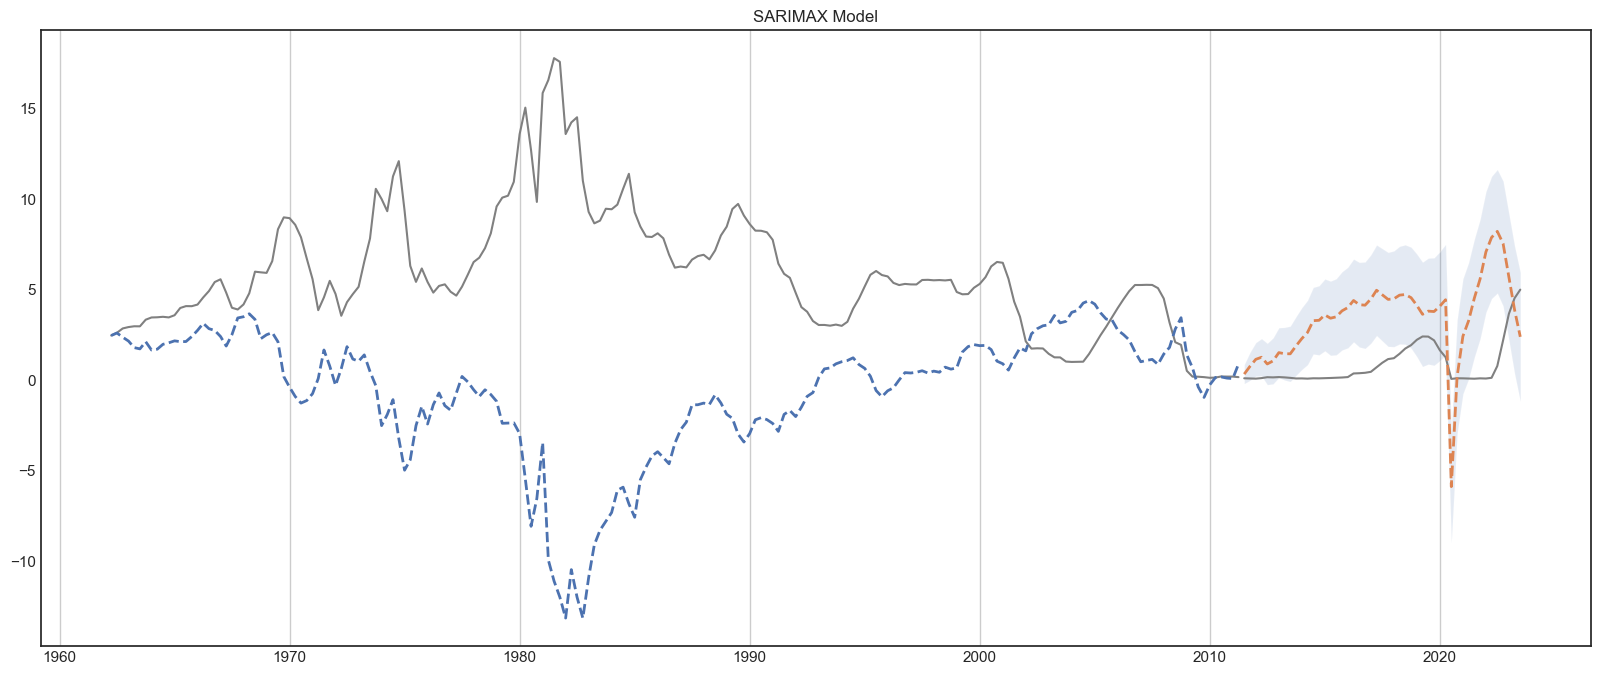

In [165]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'gray')
ax.plot(test_df.index, test_df['FEDFUNDS'], 'gray')
ax.plot(train_pred_SARIM.index, train_pred_SARIM['mean'], linestyle='--', linewidth=2)
ax.plot(test_pred_SARIM.index, test_pred_SARIM['mean'], linestyle='--', linewidth=2)
ax.fill_between(test_pred_SARIM.index, predict_ci['lower'], predict_ci['upper'], alpha=0.15)

ax.set(title='SARIMAX Model');

In [166]:
model_stats_df = model_results('SARIMAX_train',y_train, train_pred_SARIM['mean'], result_model.aic, model_stats_df )
model_stats_df = model_results('SARIMAX_test', y_test, test_pred_SARIM['mean'], 0, model_stats_df )

# auto arima

In [167]:
# Initiate and Fit Model
arima_model = pm.auto_arima(y = y_train, 
                            X = X_train_trf,
                            #p=6,
                            d = 1,
                            #m = 4,
                            #test='adf', 
                            seasonal=True, 
                            n_jobs = 10,
                            #error_action='ignore',  
                            suppress_warnings=False, n_fits=1000,
                            stepwise=True, #random='random',
                            trace=True)

arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=478.377, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=494.907, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=495.891, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=490.922, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=492.948, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=488.062, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=487.369, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=479.130, Time=0.18 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=478.908, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=488.572, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=486.796, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=486.268, Time=0.16 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=476.400, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=486.062, 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  197
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -229.200
Date:                Mon, 01 Jan 2024   AIC                            476.400
Time:                        19:59:52   BIC                            505.903
Sample:                    03-31-1962   HQIC                           488.344
                         - 03-31-2011                                         
Covariance Type:                  opg                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
num__gap_inf                0.8975      0.284      3.155      0.002       0.340       1.455
num__gap_ue                -2.3382      0.330     -7.086      0.000      -2.985      -1.691
num__Real_Interest_Rate     0.1013      0.354      0.286      0.775      -0.592       0.795
num__FEDFUNDS-1            -4.3421      0.406    -10.692      0.000      -5.138      -3.546
ar.L1                       0.2399      0.084      2.872      0.004       0.076       0.404
ar.L2                      -0.9055      0.050    -18.063      0.000      -1.004      -0.807
ma.L1                      -0.1550      0.155     -1.001      0.317      -0.459       0.148
ma.L2                       0.7651      0.086      8.893      0.000       0.596       0.934
sigma2                      0.6054      0.042     14.438      0.000       0.523       0.688
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):              1413.52
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                             1.70
Prob(H) (two-sided):                  0.04   Kurtosis:                        15.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<br>

### Model Diagnostics
Here's a brief interpretation of the AIC in the context of auto_arima:

- Lower AIC value: A lower AIC indicates a better trade-off between model goodness of fit and complexity. Among competing ARIMA models, the one with the lowest AIC is generally preferred.
- Comparing AIC values: When comparing models fitted by auto_arima, select the model with the lowest AIC value as it suggests the best balance between explaining the variance in the data and model complexity.
- AIC as a relative measure: The AIC doesn't provide an absolute measure of goodness of fit, but rather a relative measure among candidate models. You can compare AIC values across different models to identify the one that best fits the data while keeping the model as simple as possible.


According to the model summary, the model meets the condition of independence in the residuals (no correlation) because the p-value of the Ljung-Box test (Prob(Q)) is greater than 0.05, so we cannot reject the null hypothesis of independence, but we cannot say that the residual distribution is homoscedastic (constant variance) because the p-value of the Heteroskedasticity test (Prob(H)) is smaller than 0.05.

This time, the p-value of the Heteroskedasticity test is greater than 0.05, indicating that the model explains better the variance in the data. This model outperforms the previous one in terms of dependability. This demonstrates that ARIMA is superior for short-term forecasting.

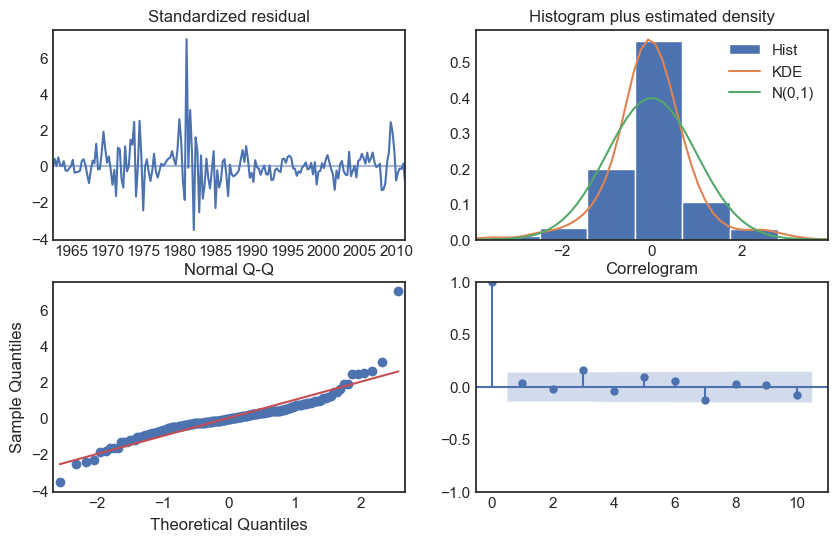

In [168]:
arima_model.plot_diagnostics()
plt.show()

We can see from the model plots that the Correlogram does not show any significant correlation in the residuals. The standardized residual plot depicts variance change, while the normal Q-Q plot demonstrates that the residuals do not follow a normal distribution (but this is not a strict requirement to validate the model).

In [169]:
predict, confint = arima_model.predict_in_sample(X=X_train_trf, return_conf_int=True)
train_pred_pmdarima = pd.DataFrame(predict)
train_pred_pmdarima.columns = ['mean']
train_pred_pmdarima['lower'] = confint[:,0]
train_pred_pmdarima['upper'] = confint[:,1]
train_pred_pmdarima.shape

(197, 3)

result_model.summary().tables[1]

arima_model.summary().tables[1]

In [170]:
table = arima_model.summary().tables[1].data
table_df = pd.DataFrame(table[1:], columns=table[0])
table_df.columns = ['feature','coef','std_err','z','p_value','[0.025','0.975]']
table_df = table_df[['feature','coef','p_value']]
table_df['coef'] = pd.to_numeric(table_df['coef'], errors='coerce')
table_df['p_value'] = pd.to_numeric(table_df['p_value'], errors='coerce')
table_df['color'] = np.where(table_df['p_value'] > 0.05, 'lightgray', '#1f77b4')

table_df

feature    coef  p_value      color
0             num__gap_inf  0.8975   0.0020    #1f77b4
1              num__gap_ue -2.3382   0.0000    #1f77b4
2  num__Real_Interest_Rate  0.1013   0.7750  lightgray
3          num__FEDFUNDS-1 -4.3421   0.0000    #1f77b4
4                    ar.L1  0.2399   0.0040    #1f77b4
5                    ar.L2 -0.9055   0.0000    #1f77b4
6                    ma.L1 -0.1550   0.3170  lightgray
7                    ma.L2  0.7651   0.0000    #1f77b4
8                   sigma2  0.6054   0.0000    #1f77b4

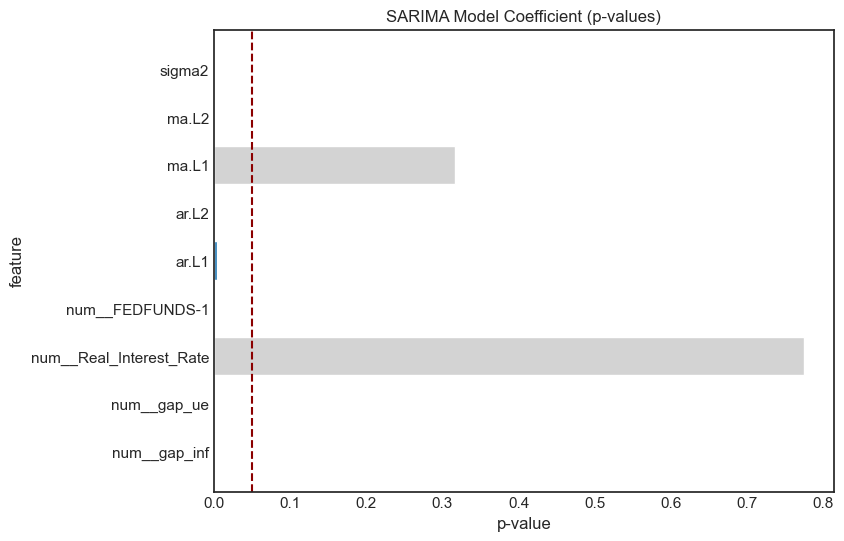

In [171]:
# Plot the MSE values against alphas
plt.figure(figsize=(8, 6))
plt.barh(table_df['feature'], table_df['p_value'], color=table_df['color'])

#plt.legend()
plt.xlabel('p-value')
plt.ylabel('feature')
plt.title('SARIMA Model Coefficient (p-values)')
plt.axvline(x=0.05, color='darkred', linestyle='--', label='Threshold: x = 0.05')

plt.grid(False)
plt.show()

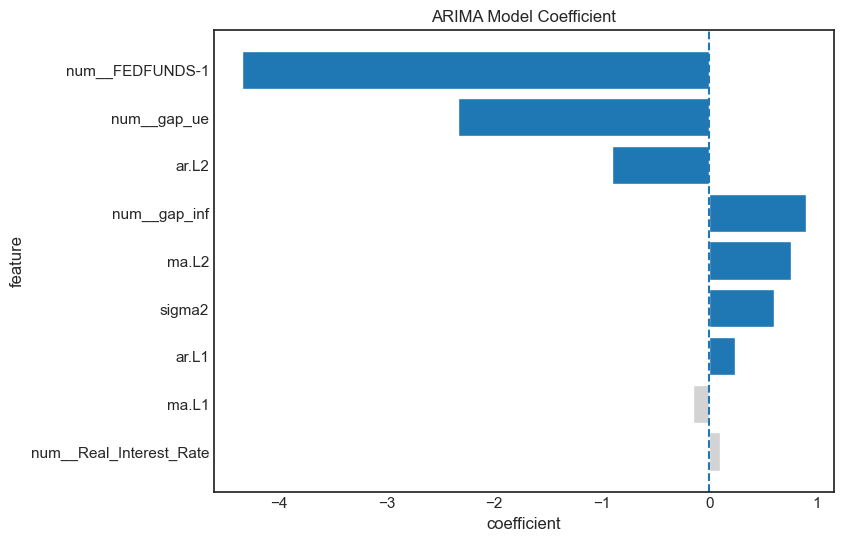

In [172]:
# Plot the MSE values against alphas
t_df = table_df.sort_values(by=['coef'], key=pd.Series.abs , ascending=True ).copy()
#t_df = table_df

plt.figure(figsize=(8, 6))
plt.barh(t_df['feature'], t_df['coef'], color=t_df['color'])

#plt.legend()
plt.xlabel('coefficient')
plt.ylabel('feature')
plt.title('ARIMA Model Coefficient')
plt.axvline(x=0, color='#1f77b4', linestyle='--', label='Base Line: x = 0')

plt.grid(False)
plt.show()

### Observations Analysis

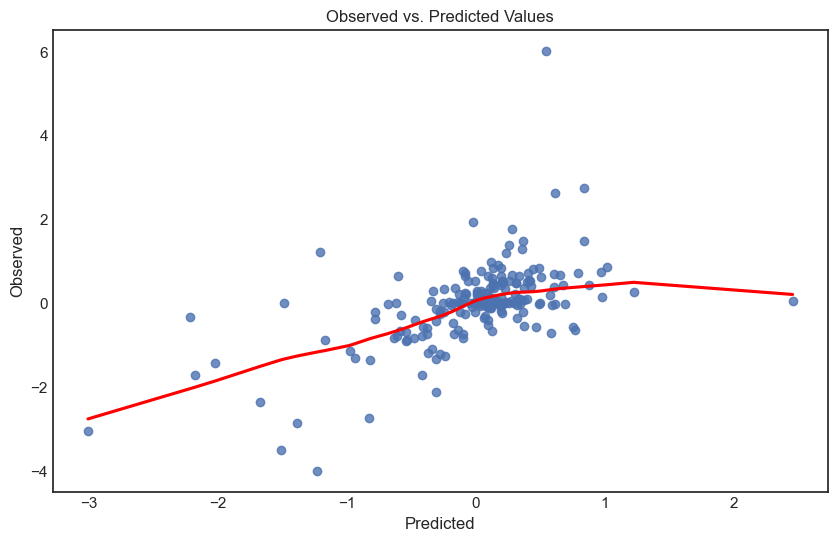

In [173]:
fig, ax = plt.subplots(1)

sns.regplot(x=train_pred_pmdarima['mean'], y=y_train, lowess=True, ax=ax, line_kws={'color': 'red'})
ax.set_title('Observed vs. Predicted Values', fontsize=12)
ax.set(xlabel='Predicted', ylabel='Observed')

plt.show()

### Residual Analysis

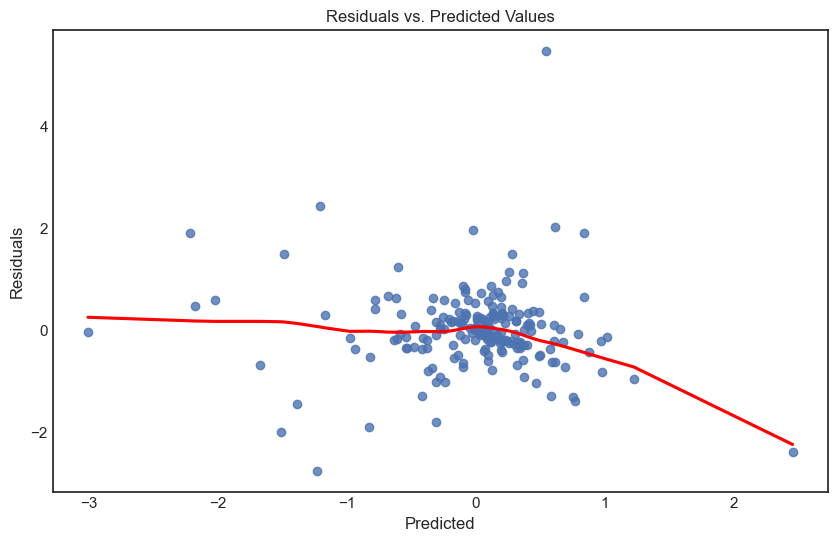

In [174]:
# independence of residuals
residuals = arima_model.resid()

fig, ax = plt.subplots(1)
sns.regplot(x=train_pred_pmdarima['mean'], y=residuals, lowess=True, ax=ax, line_kws={'color': 'red'})
ax.set_title('Residuals vs. Predicted Values', fontsize=12)
ax.set(xlabel='Predicted', ylabel='Residuals')

plt.show()

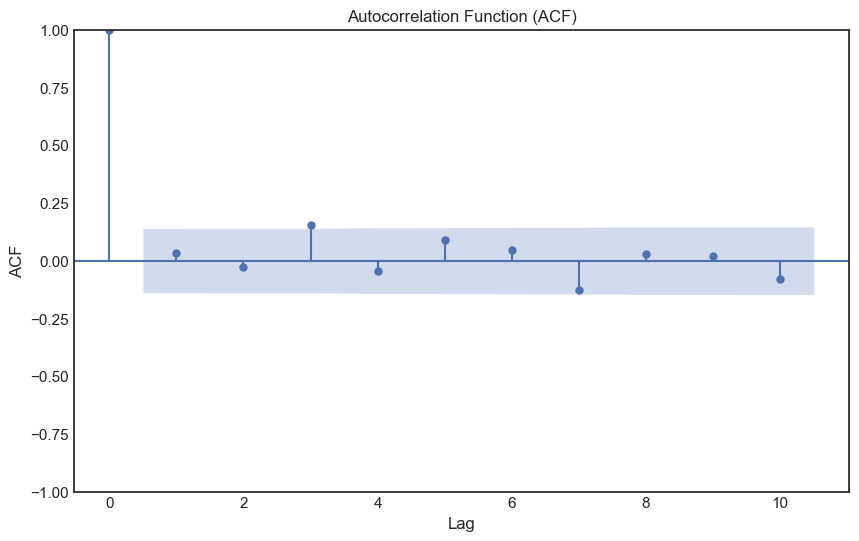

In [175]:
acf = smt.graphics.plot_acf(residuals, lags=lag_num , alpha=alpha)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.title('Autocorrelation Function (ACF)')
acf.show()

The **Ljung-Box** test is used to assess whether autocorrelation exists in a time series at different lag intervals. It examines whether there is any significant correlation between the residuals of a model at various lags.

- H0: The residuals are independently distributed. (< 0.05 evidence of autocorrelation)
- HA: The residuals are not independently distributed; they exhibit serial correlation (> 0.05 fail to reject null hypothesis)

Autocorrelation in residuals implies that the model has not captured all the information in the time series data.
Ideally, residuals should not display significant autocorrelation, indicating that the model has successfully accounted for the temporal dependencies in the data.

In [176]:
lags = min(10, len(residuals)//5)  # Adjust the number of lags as needed
res_df = acorr_ljungbox(residuals, lags=lags)
res_df['lag'] = res_df.index
res_df = res_df.reindex(columns=['lag','lb_stat','lb_pvalue'])

# Print Ljung-Box test results
print("Ljung-Box Test Results:")
res_df

Ljung-Box Test Results:


lag  lb_stat  lb_pvalue
1     1   0.2313     0.6305
2     2   0.3697     0.8312
3     3   5.0321     0.1695
4     4   5.4855     0.2410
5     5   7.1206     0.2118
6     6   7.5719     0.2712
7     7  10.8342     0.1460
8     8  10.9884     0.2024
9     9  11.0732     0.2707
10   10  12.3421     0.2628

The het_arch() function performs the Ljung-Box test for the squared residuals to test for the presence of autocorrelation in squared residuals, indicating heteroskedasticity. A low p-value (< 0.05) suggests evidence against the null hypothesis of no heteroskedasticity, indicating the presence of heteroskedasticity in the time series residuals.

ARCH Test: A lower p-value (< 0.05) suggests evidence against constant variance (presence of heteroskedasticity). 

A higher p-value indicates that there is no strong evidence against constant variance.

In [177]:
res = het_arch(residuals)
print('--- heteroskedasticity -- ')
print('Ljung-Box Test Results: ',res[0], '  ' , 'p_val: ', round(res[1],10))

--- heteroskedasticity -- 
Ljung-Box Test Results:  26.06285295981863    p_val:  0.0036565655


In [178]:
print('aic', result_model.aic)

aic 476.39968423021935


## Test

In [179]:
forecast, confint = arima_model.predict(len(y_test) , X=X_test_trf, return_conf_int=True)
test_pred_pmdarima = pd.DataFrame(forecast)
test_pred_pmdarima.columns = ['mean']
test_pred_pmdarima['lower'] = confint[:,0]
test_pred_pmdarima['upper'] = confint[:,1]
test_pred_pmdarima.shape

(49, 3)

In [180]:
model_stats_df = model_results('pmdarima_train',y_train, train_pred_pmdarima['mean'], arima_model.aic() , model_stats_df )
model_stats_df = model_results('pmdarima_test', y_test, test_pred_pmdarima['mean'], 0 , model_stats_df )

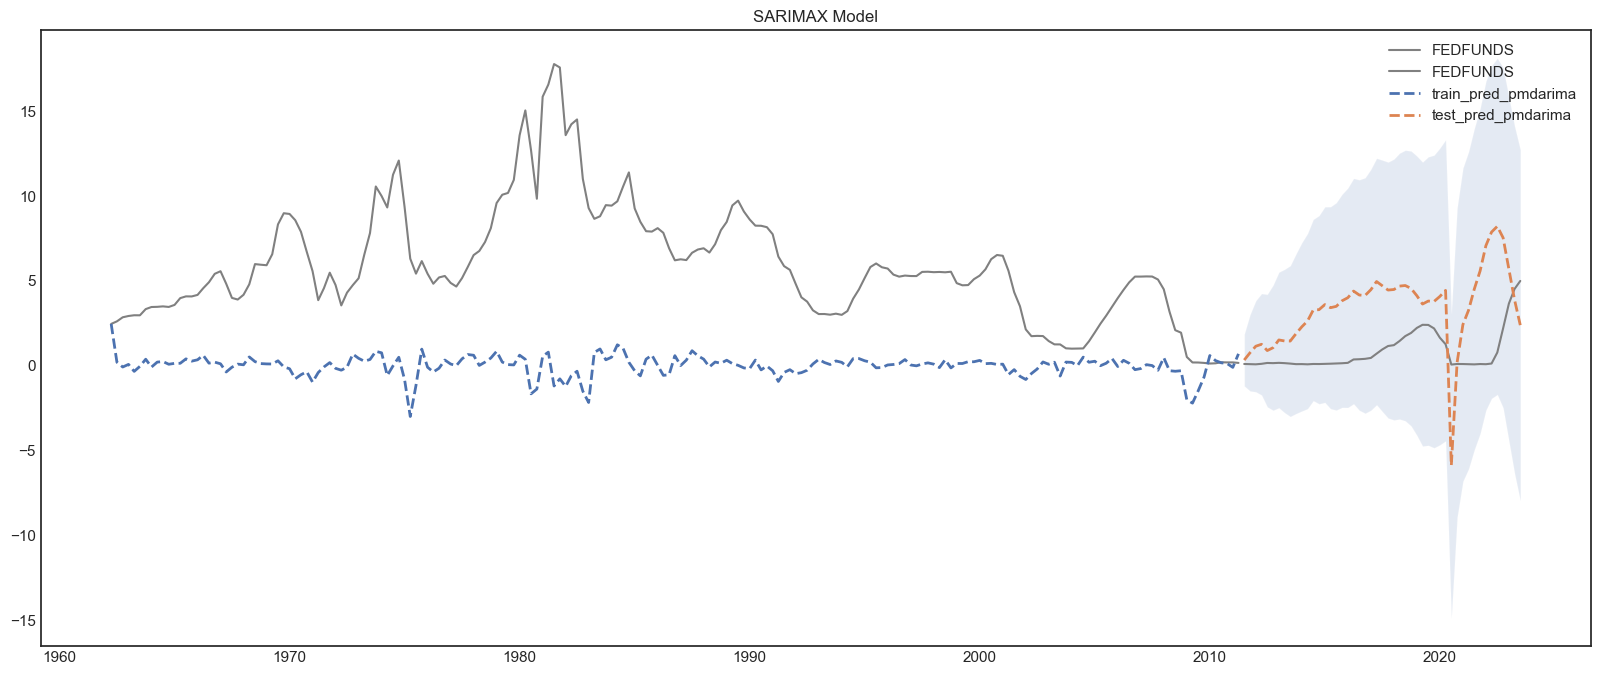

In [181]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'gray')
ax.plot(test_df.index, test_df['FEDFUNDS'], 'gray')
ax.plot(train_pred_pmdarima.index, train_pred_pmdarima['mean'], linestyle='--', linewidth=2)
ax.plot(test_pred_pmdarima.index, test_pred_pmdarima['mean'], linestyle='--', linewidth=2)
ax.fill_between(test_pred_pmdarima.index, test_pred_pmdarima['lower'], test_pred_pmdarima['upper'], alpha=0.15)

ax.legend(["FEDFUNDS","FEDFUNDS","train_pred_pmdarima","test_pred_pmdarima"])
ax.set(title='Federal Funds Effective Rate (Actual vs Predicted)');

ax.set(title='SARIMAX Model');

# ETSModel

In [182]:
#ets_model = ETSModel(train_df['FEDFUNDS_CPIAUCNS_PC1'], error='add', trend='add', seasonal='add', seasonal_periods=4)
#ets_model = ETSModel(train_df['FEDFUNDS'])
ets_model = ETSModel(y_train)

fit_ets_model = ets_model.fit(disp=False)
fit_ets_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:          FEDFUNDS_diff   No. Observations:                  197
Model:                       ETS(ANN)   Log Likelihood                -273.112
Date:                Mon, 01 Jan 2024   AIC                            552.224
Time:                        19:59:53   BIC                            562.074
Sample:                    03-31-1962   HQIC                           556.211
                         - 03-31-2011   Scale                            0.937
Covariance Type:               approx                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.0001        nan        nan        nan         nan         nan
initial_level      -0.0114      0.070     -0.163      0.870      -0.148       0.125
===================================================================================
Ljung-Box (Q):                       13.91   Jarque-Bera (JB):               763.81
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                             0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [183]:
train_pred_ets = fit_ets_model.predict(start=y_train.index[0], end=y_train.index[-1])
train_pred_ets = pd.DataFrame({'mean' : train_pred_ets})
train_pred_ets.index.name = 'DATE'
train_pred_ets.shape

(197, 1)

### Observations Analysis

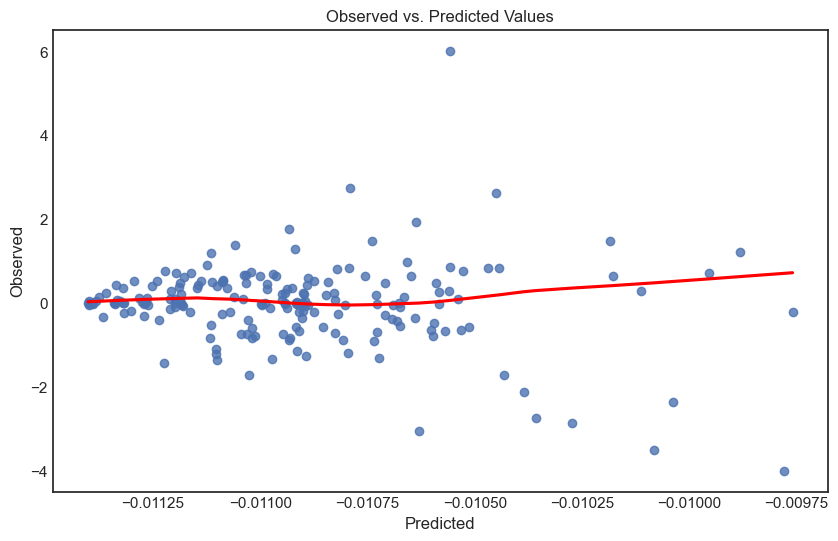

In [184]:
fig, ax = plt.subplots(1)

sns.regplot(x=train_pred_ets['mean'], y=y_train, lowess=True, ax=ax, line_kws={'color': 'red'})
ax.set_title('Observed vs. Predicted Values', fontsize=12)
ax.set(xlabel='Predicted', ylabel='Observed')

plt.show()

### Residual Analysis

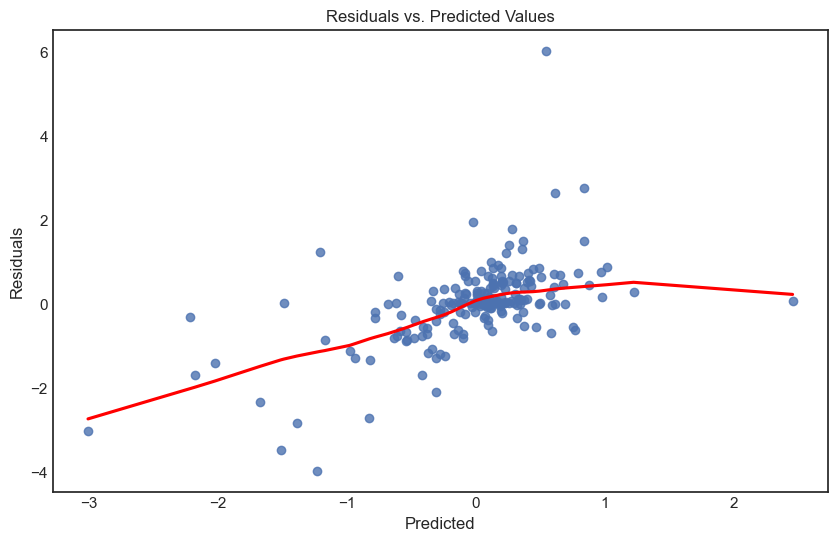

In [185]:
# independence of residuals
residuals = fit_ets_model.resid

fig, ax = plt.subplots(1)
sns.regplot(x=train_pred_pmdarima['mean'], y=residuals, lowess=True, ax=ax, line_kws={'color': 'red'})
ax.set_title('Residuals vs. Predicted Values', fontsize=12)
ax.set(xlabel='Predicted', ylabel='Residuals')

plt.show()

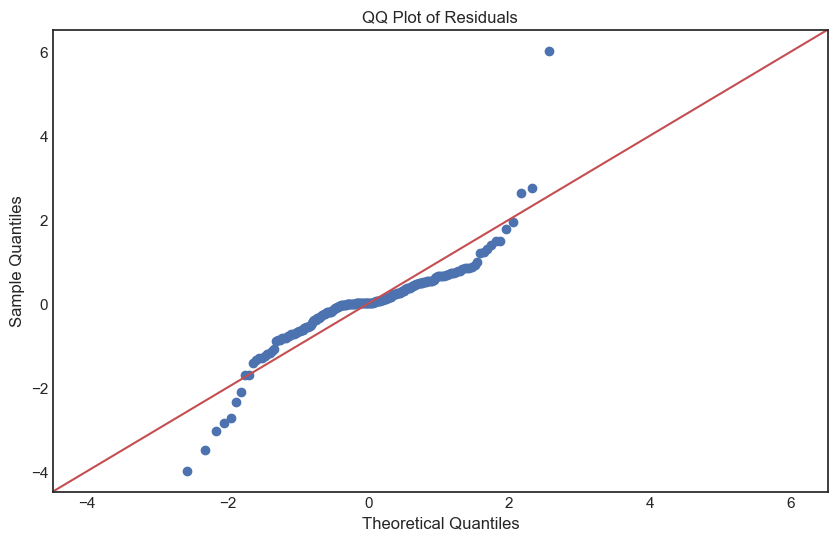

In [186]:
# Create a QQ plot for the residuals
sm.qqplot(residuals, line='45')  # 'line='45'' adds a 45-degree line for reference
plt.title('QQ Plot of Residuals')
plt.show()

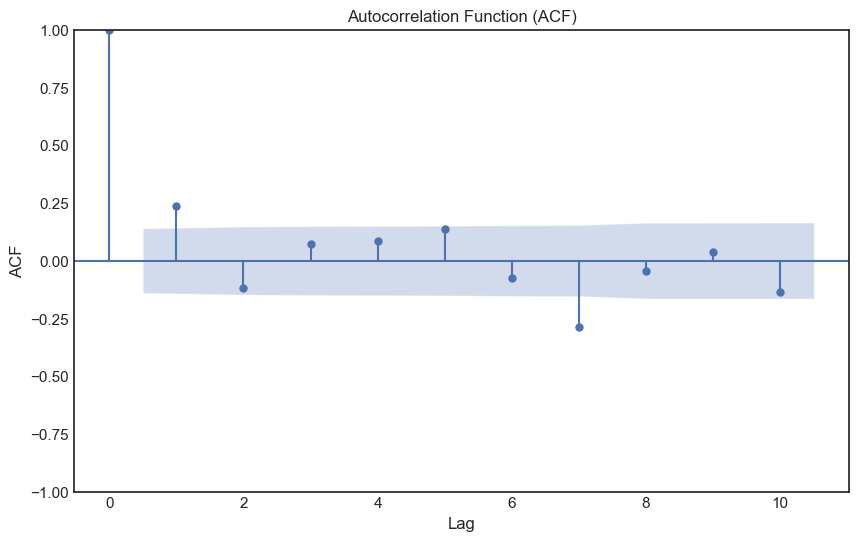

In [187]:
acf = smt.graphics.plot_acf(residuals, lags=lag_num , alpha=alpha)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.title('Autocorrelation Function (ACF)')
acf.show()

The **Ljung-Box** test is used to assess whether autocorrelation exists in a time series at different lag intervals. It examines whether there is any significant correlation between the residuals of a model at various lags.

- H0: The residuals are independently distributed. (< 0.05 evidence of autocorrelation)
- HA: The residuals are not independently distributed; they exhibit serial correlation (> 0.05 fail to reject null hypothesis)

Autocorrelation in residuals implies that the model has not captured all the information in the time series data.
Ideally, residuals should not display significant autocorrelation, indicating that the model has successfully accounted for the temporal dependencies in the data.

In [188]:
lags = min(10, len(residuals)//5)  # Adjust the number of lags as needed
res_df = acorr_ljungbox(residuals, lags=lags)

# Print Ljung-Box test results
print("Ljung-Box Test Results:")
res_df

Ljung-Box Test Results:


lb_stat  lb_pvalue
1   11.0208     0.0009
2   13.9117     0.0010
3   14.9031     0.0019
4   16.4135     0.0025
5   20.2699     0.0011
6   21.3769     0.0016
7   38.4063     0.0000
8   38.8225     0.0000
9   39.1102     0.0000
10  42.9768     0.0000

In [189]:
test_pred_ets = fit_ets_model.forecast(steps=y_test.shape[0]) 
test_pred_ets = pd.DataFrame({'mean' : test_pred_ets})
test_pred_ets.index.name = 'DATE'
test_pred_ets.shape

(49, 1)

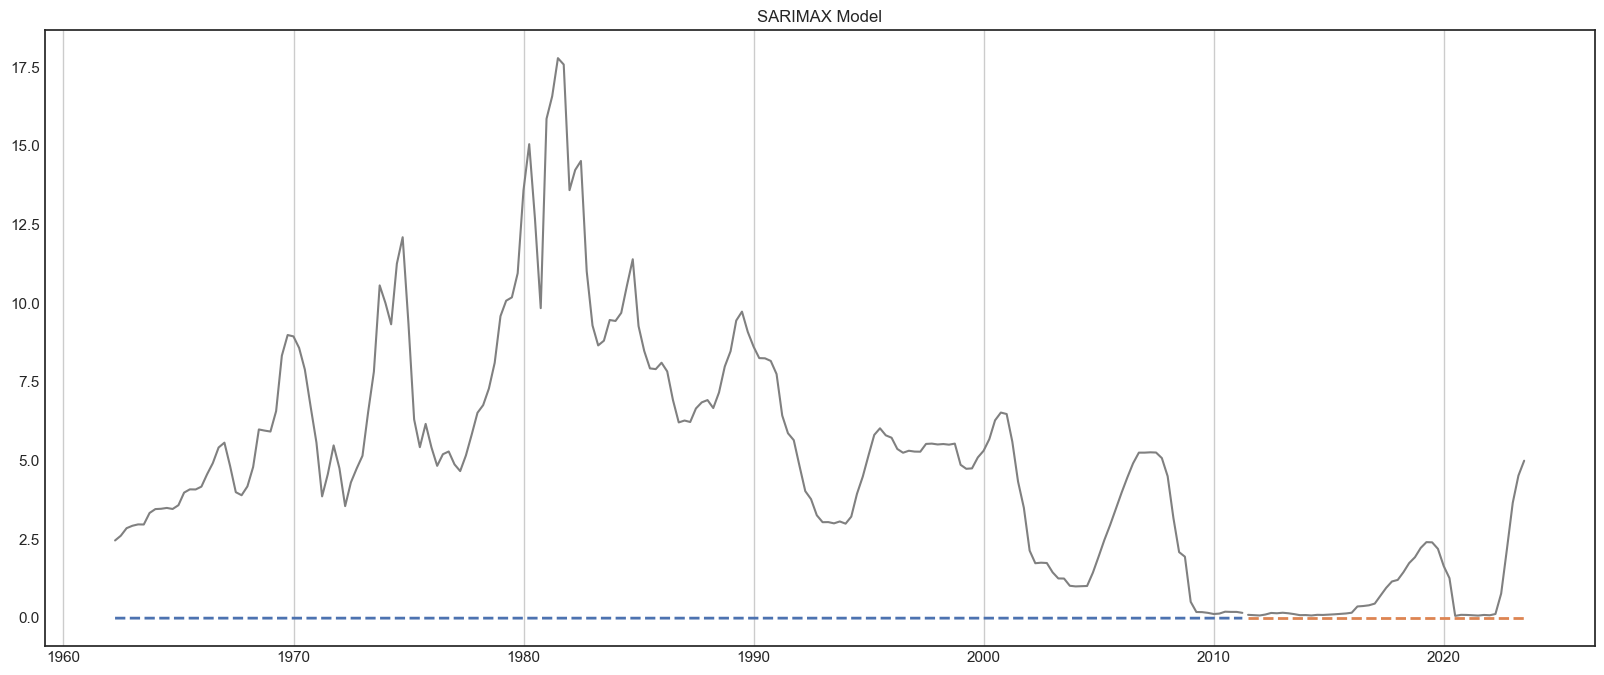

In [190]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'gray')
ax.plot(test_df.index, test_df['FEDFUNDS'], 'gray')
ax.plot(train_pred_ets.index, train_pred_ets['mean'], linestyle='--', linewidth=2)
ax.plot(test_pred_ets.index, test_pred_ets['mean'], linestyle='--', linewidth=2)
#ax.fill_between(test_pred_pmdarima.index, test_pred_pmdarima['lower'], test_pred_pmdarima['upper'], alpha=0.15)

ax.set(title='SARIMAX Model');

In [191]:
model_stats_df = model_results('ets_train',y_train, train_pred_ets['mean'], fit_ets_model.aic , model_stats_df )
model_stats_df = model_results('ets_test', y_test, test_pred_ets['mean'], 0 , model_stats_df )

# Results


- A smaller MSE indicates better performance. Lower values of MSE suggest that, on average, the model's predictions have smaller deviations from the actual values, indicating higher accuracy.
- A smaller RMSE indicates better performance. Lower values of RMSE imply that, on average, the model's predictions are closer to the actual values, suggesting higher accuracy.
- A smaller MAPE indicates better performance. Lower values of MAPE imply that, on average, the model's predictions have a smaller percentage deviation from the actual values, indicating higher accuracy.
- A smaller MAE indicates better performance. Lower values of MAE indicate that, on average, the model's predictions are closer to the actual values, implying higher accuracy.
- Lower AIC value: A lower AIC indicates a better trade-off between model goodness of fit and complexity. Among competing ARIMA models, the one with the lowest AIC is generally preferred.

In [192]:
model_stats_df

name     mse   rmse                    mape    mae      aic
0   ffef_tr_train 25.4002 5.0399                  2.1100 4.4310        0
1    ffef_tr_test 57.2779 7.5682                 41.6492 6.8936        0
2  ffef_tr2_train  1.1202 1.0584                  0.2525 0.6816        0
3   ffef_tr2_test  0.3307 0.5750                  3.4681 0.4071        0
4   SARIMAX_train 12.0606 3.4728 24,790,144,404,492.3867 2.4681 476.3997
5    SARIMAX_test 11.8171 3.4376                 18.2433 2.9472        0
6  pmdarima_train  0.6316 0.7948  6,481,902,930,689.2588 0.5042 476.3997
7   pmdarima_test 11.8171 3.4376                 18.2433 2.9472        0
8       ets_train  0.9369 0.9679    509,657,201,449.4540 0.5872 552.2241
9        ets_test  2.1316 1.4600                  1.0698 0.8632        0

long_df: (788, 3)


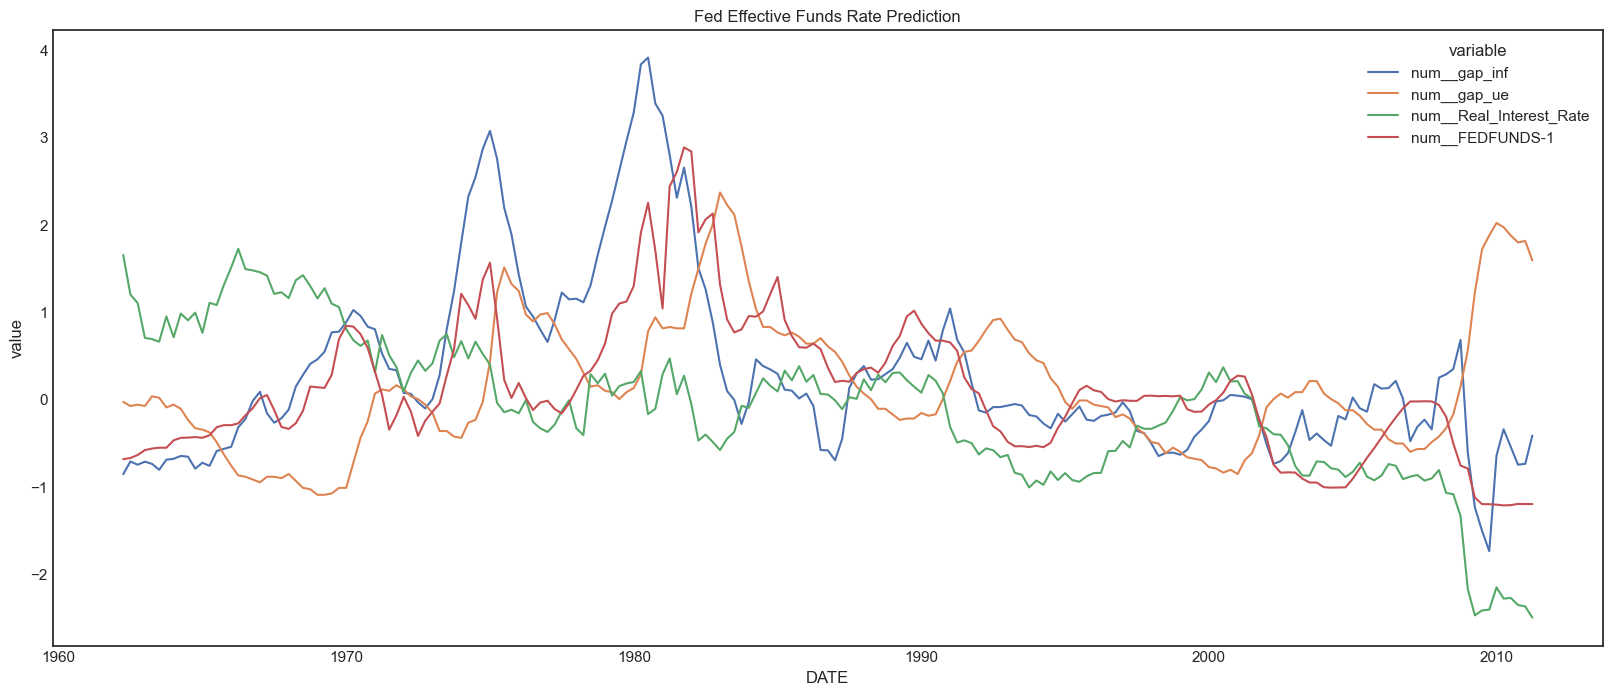

In [193]:
# Long 
long_df = X_train_trf.copy()
long_df.reset_index(inplace=True)
long_df = long_df.melt(id_vars=['DATE'])
#long_df = long_df[['DATE','FEDFUNDS','ffef_tr','gap_inf','gap_gdp']].melt(id_vars=['DATE'])
print('long_df:', long_df.shape)

# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
#ax.plot(long_df['observation_date'], long_df['value'], color='variable')
sns.lineplot(x = 'DATE', y = 'value', data=long_df, hue='variable')

ax.set(title='Fed Effective Funds Rate Prediction');

# Lasso

In [194]:
pipe_lasso = Pipeline(
    steps = [ ('preprocessor',preprocessor), ('model',linear_model.LassoCV(cv=5, 
                                                                           #alphas=[0.001, 0.01,0.05, 0.1, 0.5],
                                                                           random_state=rand_int, 
                                                                           max_iter=10000))]
)

param_lasso = {
    #'model__alpha': [0.01, 0.05, 0.1, 0.5],
    'model__verbose': [0],
}


cv = RandomizedSearchCV(estimator = pipe_lasso, 
                        param_distributions = param_lasso,
                        random_state=rand_int, 
                        scoring="neg_root_mean_squared_error")

cv.fit(X_train, y_train)
cv_results = cv.cv_results_['mean_test_score']
print('Lasso', ') Best Accuracy Score:' , cv.best_score_ , 'Parameters: {}' , cv.best_params_)

Lasso ) Best Accuracy Score: -0.8601848284226202 Parameters: {} {'model__verbose': 0}


In [195]:
lasso_best = linear_model.Lasso(alpha=cv.best_estimator_.named_steps.model.alpha_)

lasso_best.fit(X_train_trf, y_train)

train_pred_lasso = lasso_best.predict(X_train_trf)

In [196]:
feature_df = pd.DataFrame(lasso_best.coef_, t_fit.get_feature_names_out())
feature_df.columns = ['coef']
feature_df.sort_values(by=['coef'], key=pd.Series.abs , ascending=True , inplace=True)
feature_df

coef
num__Real_Interest_Rate  0.0523
num__gap_inf             0.1037
num__gap_ue             -0.1362
num__FEDFUNDS-1         -0.1745

In [197]:
feature_df.index

Index(['num__Real_Interest_Rate', 'num__gap_inf', 'num__gap_ue',
       'num__FEDFUNDS-1'],
      dtype='object')

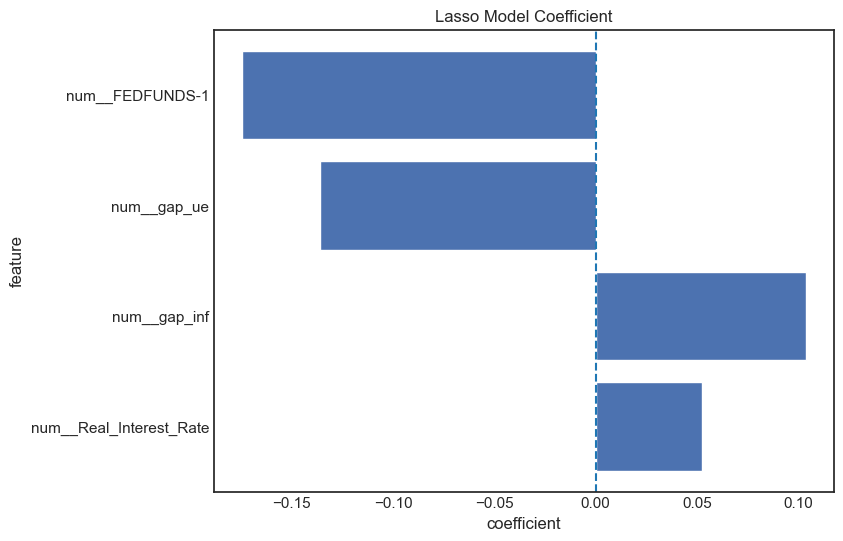

In [198]:
# Plot the MSE values against alphas
plt.figure(figsize=(8, 6))
plt.barh(feature_df.index, feature_df['coef'])
plt.axvline(x=0, color='#1f77b4', linestyle='--', label='Base Line: x = 0')

#plt.legend()
plt.xlabel('coefficient')
plt.ylabel('feature')
plt.title('Lasso Model Coefficient')
plt.grid(False)
plt.show()

### linearity assumption Interpretation:
Ideally, the scatter plot should show a strong linear relationship along the diagonal line (y = x). This indicates that the model's predictions are close to the actual values.
A scattered or disperse pattern away from the diagonal line might indicate areas where the model performs poorly, potentially highlighting non-linearity or other issues in the model.

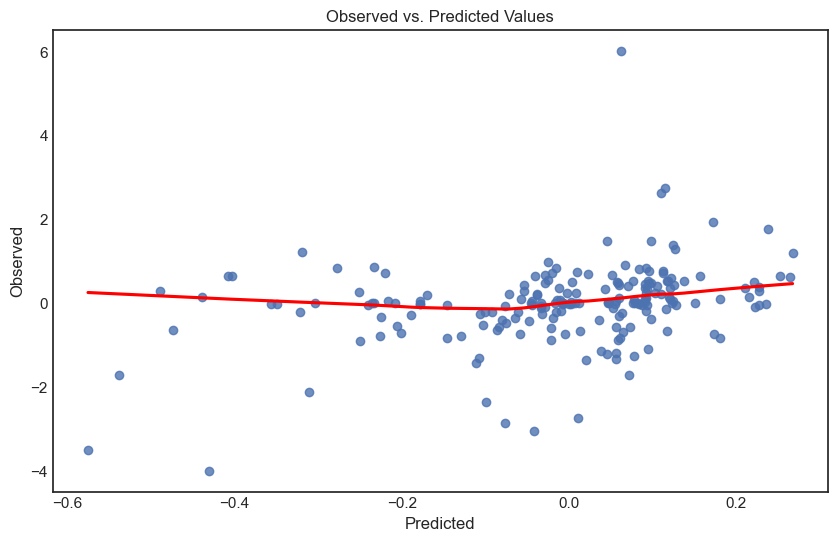

In [199]:
fig, ax = plt.subplots(1)

sns.regplot(x=train_pred_lasso, y=y_train, lowess=True, ax=ax, line_kws={'color': 'red'})
ax.set_title('Observed vs. Predicted Values', fontsize=12)
ax.set(xlabel='Predicted', ylabel='Observed')

plt.show()

### independence of residuals Iterpretation:
In the scatter plot(s), check for a consistent spread of residuals around zero. If the spread of residuals widens or narrows systematically as predicted values or predictor values change, it suggests heteroscedasticity, violating the assumption of homoscedasticity.

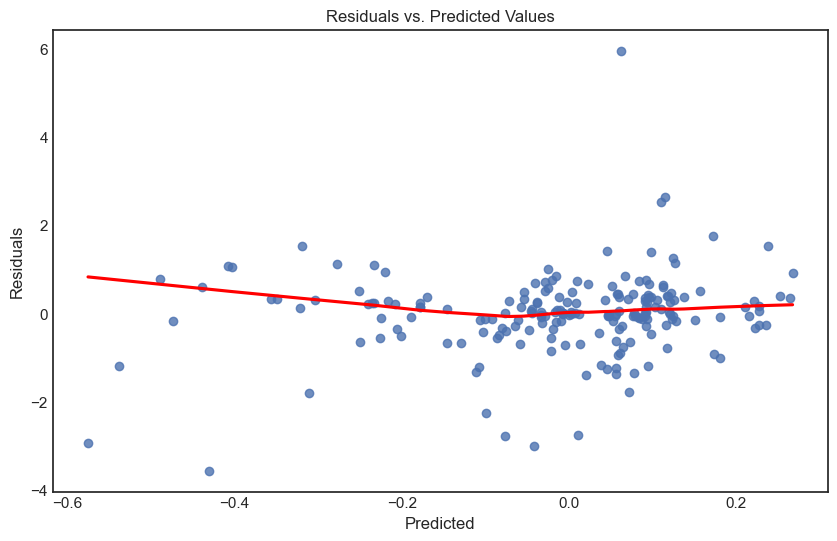

In [200]:
# independence of residuals

residuals = y_train - train_pred_lasso

fig, ax = plt.subplots(1)

sns.regplot(x=train_pred_lasso, y=residuals, lowess=True, ax=ax, line_kws={'color': 'red'})
ax.set_title('Residuals vs. Predicted Values', fontsize=12)
ax.set(xlabel='Predicted', ylabel='Residuals')

plt.show()

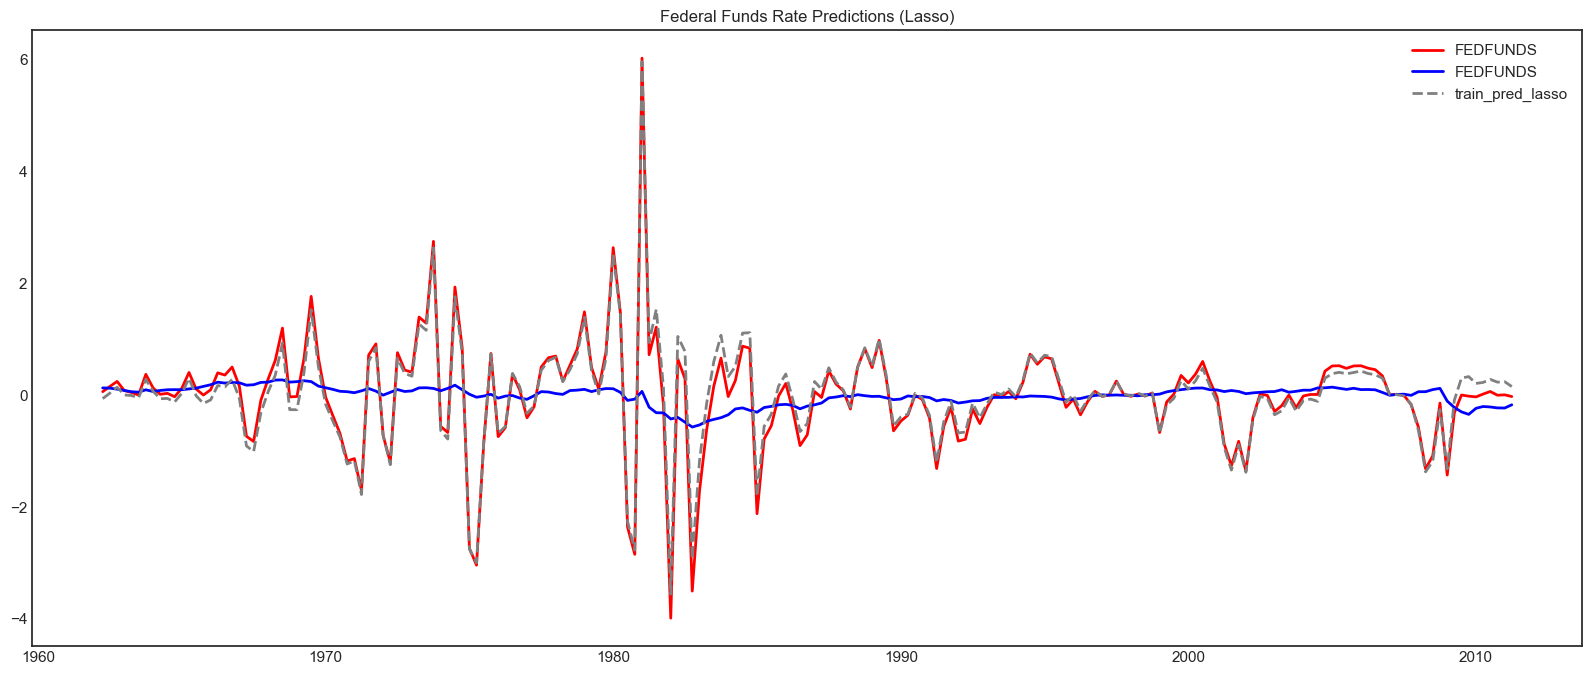

In [201]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
ax.plot(y_train.index, y_train, 'lightgray', color='red',linewidth=2)
ax.plot(y_train.index, train_pred_lasso, 'lightgray', color='blue',linewidth=2)
ax.plot(y_train.index, residuals, 'lightgray', linestyle="--",color='gray',linewidth=2)


ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_lasso","test_pred_lasso"])
ax.set(title='Federal Funds Rate Predictions (Lasso)');

plt.show()

In [202]:
# values for durbin watson test is between 0 and 4 the value close to 2 is accurate
# Durbin-Watson Test: Provides a measure (statistic) that ranges from 0 to 4. A value around 2 
# suggests no autocorrelation. Values closer to 0 indicate positive autocorrelation, 
# while values near 4 suggest negative autocorrelation.

durbin_watson_stat = durbin_watson(residuals)
print("Durbin-Watson statistic:", durbin_watson_stat)

Durbin-Watson statistic: 1.5786405249306483


In [203]:
# Perform Shapiro-Wilk test for normality
shapiro_test = shapiro(residuals)

# p-value < 0.05 - reject the null hypothesis residuals are not normally distrivuted
# Display the Shapiro-Wilk test statistic and p-value
print("Shapiro-Wilk Test Statistic:", shapiro_test.statistic)
print("Shapiro-Wilk p-value:", round(shapiro_test.pvalue,8))


# Check for normality based on the p-value
alpha = 0.05  # Set a significance level
if shapiro_test.pvalue > alpha:
    print("Sample looks Gaussian (fail to reject H0 - data is normally distributed)")
else:
    print("Sample does not look Gaussian (reject H0 - data is not normally distributed)")

Shapiro-Wilk Test Statistic: 0.8513564467430115
Shapiro-Wilk p-value: 0.0
Sample does not look Gaussian (reject H0 - data is not normally distributed)


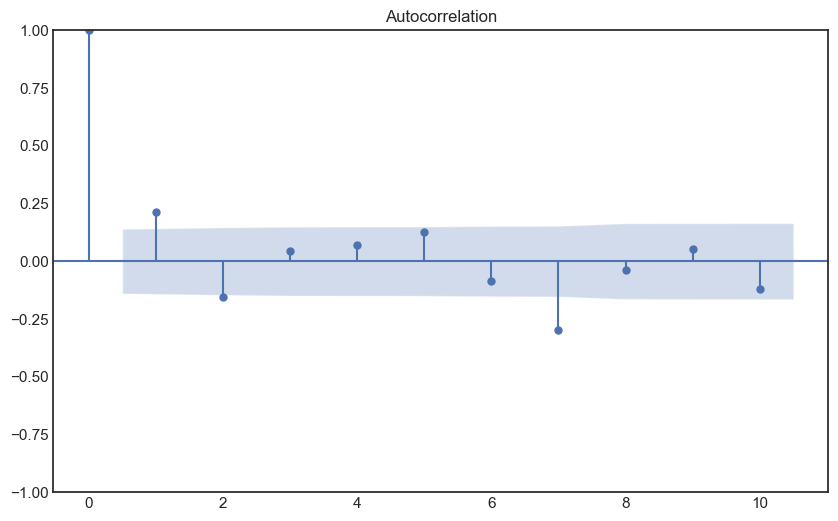

In [204]:
acf = smt.graphics.plot_acf(residuals, lags=10 , alpha=0.05)
acf.show()

In [205]:
mse = mean_squared_error(y_train, train_pred_lasso)

# Approximate AIC using the formula AIC = n * log(MSE) + 2 * k
n = len(y_train)  # Number of observations
k = np.count_nonzero(lasso_best.coef_) + 1  # Number of non-zero coefficients + intercept

aic = n * np.log(mse) + 2 * k
print("Best Alpha:", lasso_best.alpha)
print("MSE:", mse)
print("AIC Approximation:", aic)

Best Alpha: 0.049388997875936404
MSE: 0.8654286025693341
AIC Approximation: -18.47248889204132


## Test

In [206]:
X_test_trf = t_fit.transform(X_test)

X_test_trf = pd.DataFrame(X_test_trf)
X_test_trf.columns = t_fit.get_feature_names_out()
X_test_trf['DATE'] = y_test.index
X_test_trf.set_index('DATE', inplace=True)

print('X_test_const: ', X_test_trf.shape)

X_test_const:  (49, 4)


In [207]:
test_pred_lasso = lasso_best.predict(X_test_trf)
print('test_pred_lasso: ', test_pred_lasso.shape)

test_pred_lasso:  (49,)


In [208]:
residuals = y_test - test_pred_lasso

In [209]:
#model_stats_df = model_results('lasso_test', y_test, test_pred_lasso, X_test_trf.shape[0], X_test_trf.shape[1] , model_stats_df )

lasso_stats_df = model_results('ffef_tr_train', train0_df['FEDFUNDS'], train0_df['ffef_tr'], 0, None)
lasso_stats_df = model_results('ffef_tr_test', test0_df['FEDFUNDS'], test0_df['ffef_tr'], 0, lasso_stats_df)
                              
lasso_stats_df = model_results('ffef_tr2_train', train0_df['FEDFUNDS'], train0_df['ffef_tr2'], 0, lasso_stats_df )
lasso_stats_df = model_results('ffef_tr2_test', test0_df['FEDFUNDS'], test0_df['ffef_tr2'], 0, lasso_stats_df )     

lasso_stats_df = model_results('lasso_train', y_train, train_pred_lasso, aic , lasso_stats_df )
lasso_stats_df = model_results('lasso_test', y_test, test_pred_lasso, 0 , lasso_stats_df )

lasso_stats_df

name     mse   rmse                   mape    mae      aic
0   ffef_tr_train 25.4002 5.0399                 2.1100 4.4310        0
1    ffef_tr_test 57.2779 7.5682                41.6492 6.8936        0
2  ffef_tr2_train  1.1202 1.0584                 0.2525 0.6816        0
3   ffef_tr2_test  0.3307 0.5750                 3.4681 0.4071        0
4     lasso_train  0.8654 0.9303 5,533,504,172,850.7275 0.5749 -18.4725
5      lasso_test  1.9144 1.3836                 1.4919 0.8393        0

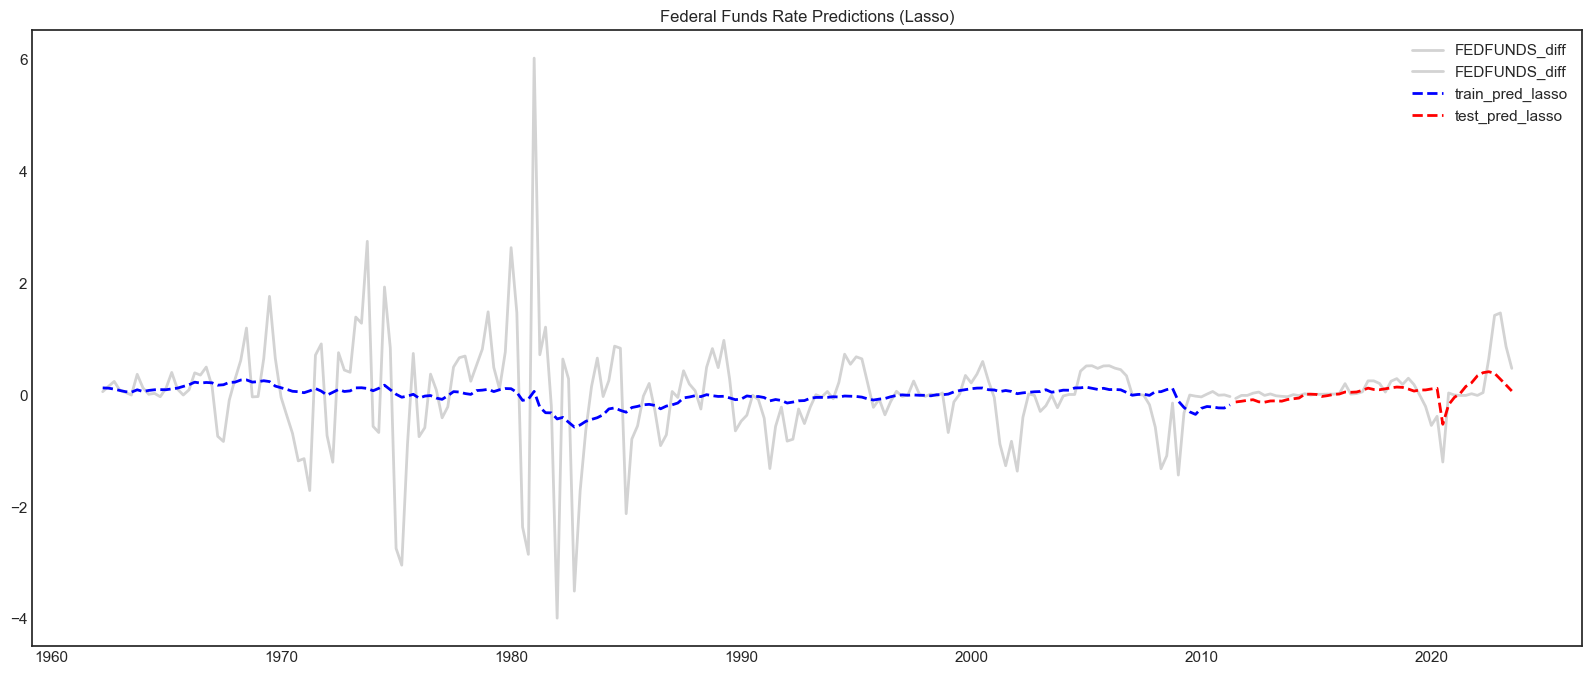

In [210]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS_diff'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS_diff'], 'lightgray', linewidth=2)
ax.plot(train_df.index, train_pred_lasso, color='blue', linestyle='--', linewidth=2)
ax.plot(test_df.index, test_pred_lasso, color='red', linestyle='--', linewidth=2)

ax.legend(["FEDFUNDS_diff", "FEDFUNDS_diff","train_pred_lasso","test_pred_lasso"])
ax.set(title='Federal Funds Rate Predictions (Lasso)');

plt.show()

# Result - Lasso

In [211]:
lasso_stats_df[['name','mse','rmse','mae', 'aic']]

name     mse   rmse    mae      aic
0   ffef_tr_train 25.4002 5.0399 4.4310        0
1    ffef_tr_test 57.2779 7.5682 6.8936        0
2  ffef_tr2_train  1.1202 1.0584 0.6816        0
3   ffef_tr2_test  0.3307 0.5750 0.4071        0
4     lasso_train  0.8654 0.9303 0.5749 -18.4725
5      lasso_test  1.9144 1.3836 0.8393        0

## Sharpe

In [212]:
model = cv.best_estimator_.named_steps.model
model

LassoCV(cv=5, max_iter=10000, random_state=12, verbose=0)

In [213]:
explainer = None
shap_values = None

In [214]:
try:
    explainer = shap.Explainer(lasso_best, X_test_trf)
    shap_values = explainer(X_test_trf)
except Exception as e:
    print('-- error ')
    print(e)

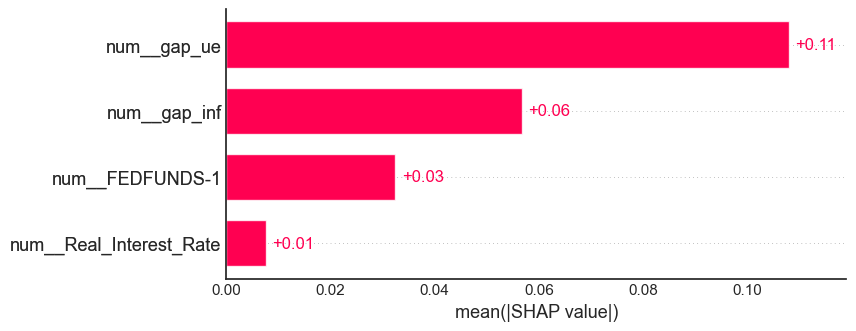

In [215]:
if (shap_values is not None):
    shap.plots.bar(shap_values, max_display=20)

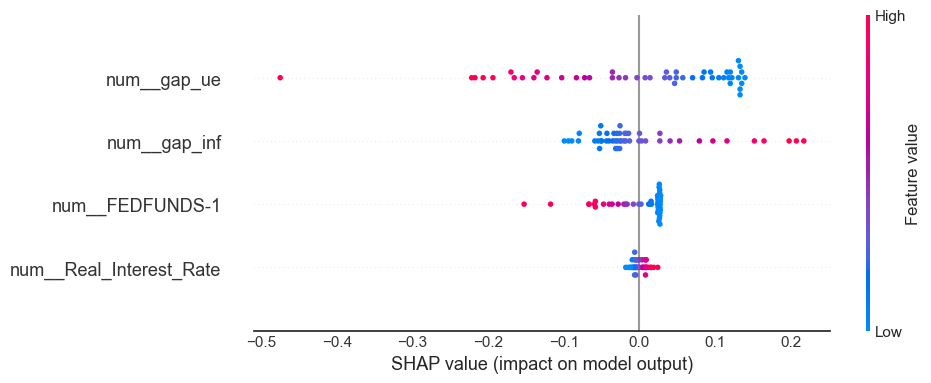

In [216]:
if (shap_values is not None):
    shap.summary_plot(shap_values, X_test_trf, plot_size=(10,4))

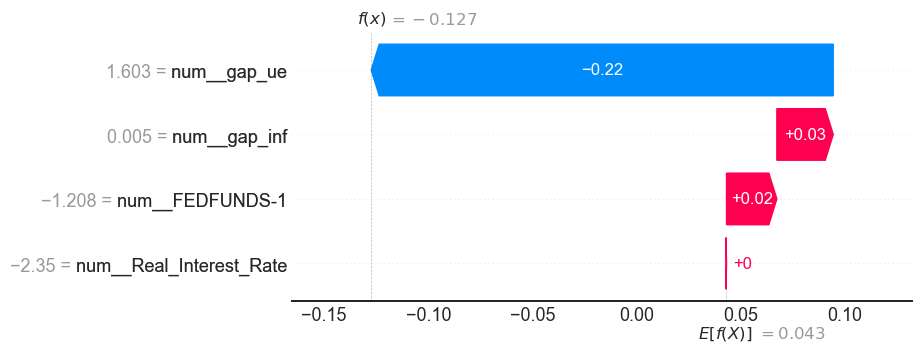

In [217]:
if (shap_values is not None):
    shap.plots.waterfall(shap_values[0], max_display=20)


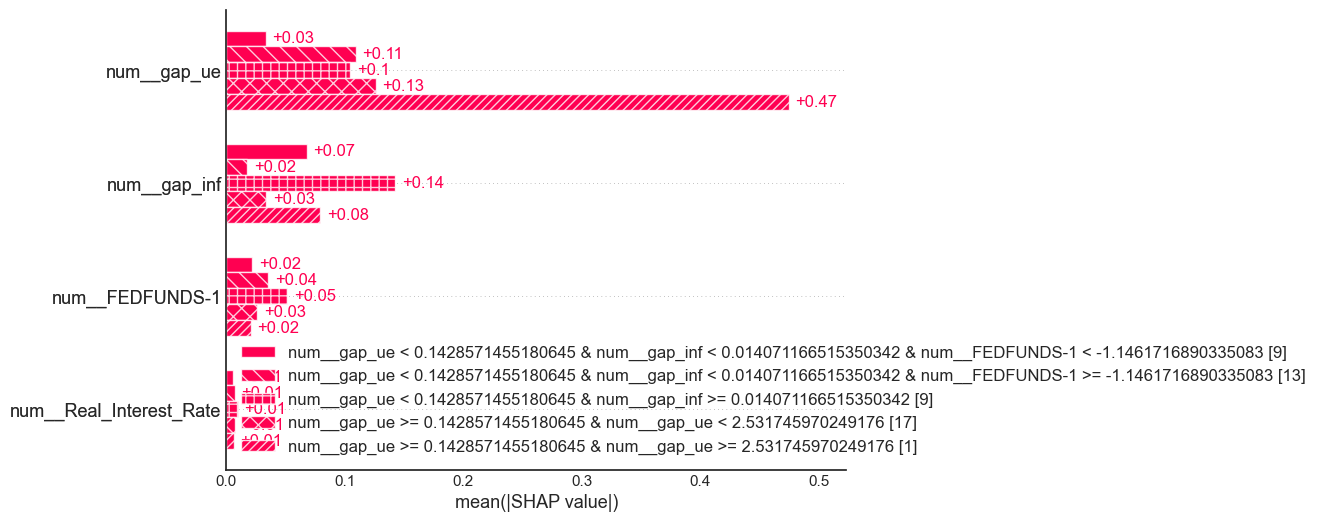

In [218]:
if (shap_values is not None):
    shap.plots.bar(shap_values.cohorts(5).abs.mean(0),  max_display=10)

In [219]:
shap.force_plot(shap_values, plot_cmap = "PkYg")

if (shap_values is not None):
    shap.plots.scatter(shap_values[:,"num__gap_ue"])

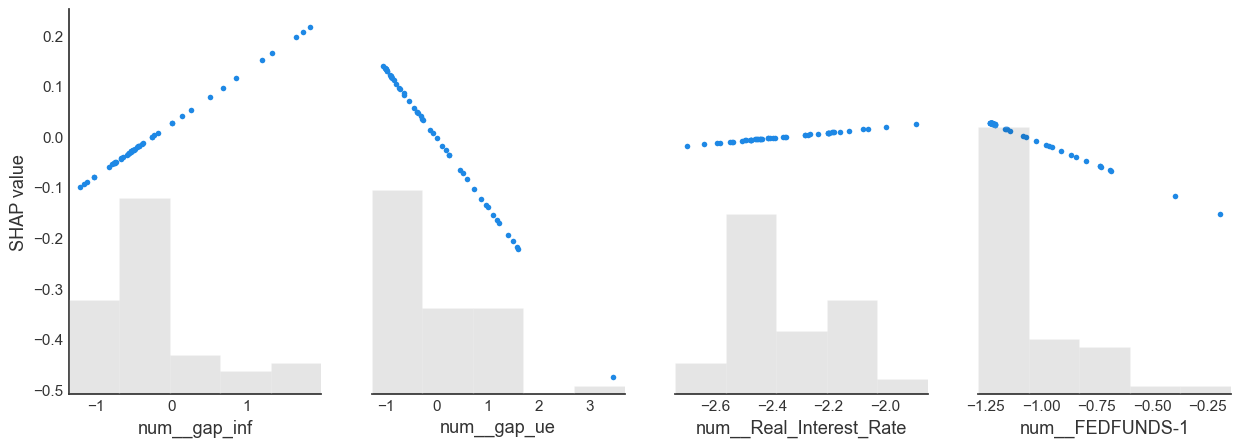

In [220]:
if (shap_values is not None):
    shap.plots.scatter(shap_values)